## Import Libraries

In [ ]:
!pip install pyrsgis
!pip install patchify
!pip install tifffile

In [ ]:
import os
from glob import glob
import numpy as np
from tqdm.notebook import tqdm
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input, TimeDistributed, Flatten, Conv2D, LSTM, MaxPooling2D, Reshape, Dropout,  UpSampling2D, AveragePooling1D, GRU, AveragePooling2D, AveragePooling3D, Conv2DTranspose
from keras.layers import ConvLSTM2D, BatchNormalization, Conv3D, GlobalAveragePooling3D, concatenate, Average
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
#GlobalAveragePooling1D, ConvLSTM1D
import time

from osgeo import gdal
from pyrsgis import raster
from patchify import patchify
import tifffile as tiff

import numpy as np
import skimage.segmentation as seg
import skimage.color as color
import matplotlib.pyplot as plt
import shutil
import pandas as pd


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Load Data

In [ ]:
def load_data(path):

  # data_folders = next(os.walk(path))[1] #['images_train', 'masks_train', 'masks_test', 'images_test']
  # print(data_folders)
  masks=""
  images_train_patches = masks_train_patches = images_validation_patches = masks_validation_patches = images_test_patches = masks_test_patches = 0
  images_sar_test_patches_2021 = masks_sar_test_patches_2021 = images_test_patches_2020 = masks_test_patches_2020 = images_test_patches_2020_2021 = masks_test_patches_2020_2021 = 0

  images_train_count = masks_train_count = images_validation_count = masks_validation_count = images_test_count = masks_test_count = 0
  images_sar_test_count_2021 = masks_sar_test_count_2021 = images_test_count_2020 = masks_test_count_2020 = images_test_count_2020_2021 = masks_test_count_2020_2021 = 0

  for data_folders in os.listdir(path): #/first_patch/

    # print(data_folders)
    dir0 = os.path.join(path, data_folders) #/content/gdrive/MyDrive/Crop Mapping/Sentinel Hub Dataset for Code/test/first_patch/images_train
    # print(dir0)

    for data_split_folder in os.listdir(dir0):   #/images_train/

      if(data_folders=="images_train"):
        images_train_patches += 1
        images_train_count = 0
      if(data_folders=="masks_train"):
        masks_train_patches += 1
        masks_train_count = 0
      if(data_folders=="images_validation"):
        images_validation_patches += 1
        images_validation_count = 0
      if(data_folders=="masks_validation"):
        masks_validation_patches += 1
        masks_validation_count = 0
      if(data_folders=="images_test"):
        images_test_patches += 1
        images_test_count = 0
      if(data_folders=="masks_test"):
        masks_test_patches += 1
        masks_test_count = 0
      if(data_folders=="images_test_2020"):
        images_test_patches_2020 += 1
        images_test_count_2020 = 0
      if(data_folders=="masks_test_2020"):
        masks_test_patches_2020 += 1
        masks_test_count_2020 = 0
      if(data_folders=="images_test_2020-2021"):
        images_test_patches_2020_2021 += 1
        images_test_count_2020_2021 = 0
      if(data_folders=="masks_test_2020-2021"):
        masks_test_patches_2020_2021 += 1
        masks_test_count_2020_2021 = 0
      if(data_folders=="images_sargodha_2021"):
        images_sar_test_patches_2021 += 1
        images_sar_test_count_2021 = 0
      if(data_folders=="masks_sargodha_2021"):
        masks_sar_test_patches_2021 += 1
        masks_sar_test_count_2021 = 0

      dir1 = os.path.join(dir0, data_split_folder) #/content/gdrive/MyDrive/Crop Mapping/Sentinel Hub Dataset for Code/test/first_patch/11_images_train
      # print(dir1)

      for files in os.listdir(dir1):   #/11_images_train/
        if(data_folders=="images_train"):
          images_train_count += 1
        if(data_folders=="masks_train"):
          masks_train_count += 1
        if(data_folders=="images_validation"):
          images_validation_count += 1
        if(data_folders=="masks_validation"):
          masks_validation_count += 1
        if(data_folders=="images_test"):
          images_test_count += 1
        if(data_folders=="masks_test"):
          masks_test_count += 1
        if(data_folders=="images_test_2020"):
          images_test_count_2020 += 1
        if(data_folders=="masks_test_2020"):
          masks_test_count_2020 +=1
        if(data_folders=="images_test_2020-2021"):
          images_test_count_2020_2021 += 1
        if(data_folders=="masks_test_2020-2021"):
          masks_test_count_2020_2021 += 1
        if(data_folders=="images_sargodha_2021"):
          images_sar_test_count_2021 += 1
        if(data_folders=="masks_sargodha_2021"):
          masks_sar_test_count_2021 += 1

  return images_train_patches, images_train_count, masks_train_patches, masks_train_count, \
  images_validation_patches, images_validation_count, masks_validation_patches, \
  masks_validation_count, images_test_patches, images_test_count, masks_test_patches, \
  masks_test_count,  images_test_patches_2020, images_test_count_2020,  masks_test_patches_2020,\
  masks_test_count_2020 ,  images_test_patches_2020_2021, images_test_count_2020_2021, masks_test_patches_2020_2021,\
  masks_test_count_2020_2021, images_sar_test_patches_2021, images_sar_test_count_2021, masks_sar_test_patches_2021, \
  masks_sar_test_count_2021
# "/content/gdrive/MyDrive/Crop Mapping/Sentinel Hub Dataset for Code/tile_10m_top/Data_Split/"


path = "/content/Data_Split/"
# data_folders = next(os.walk(path))[1]
images_train_patches, images_train_count, masks_train_patches, masks_train_count, images_validation_patches,\
images_validation_count, masks_validation_patches, masks_validation_count, images_test_patches, images_test_count,\
masks_test_patches, masks_test_count, images_test_patches_2020, images_test_count_2020,  masks_test_patches_2020,\
masks_test_count_2020 ,  images_test_patches_2020_2021, images_test_count_2020_2021, masks_test_patches_2020_2021,\
masks_test_count_2020_2021, images_sar_test_patches_2021, images_sar_test_count_2021, masks_sar_test_patches_2021, \
masks_sar_test_count_2021 = load_data(path)


print(f"Number of training Image patches: {images_train_patches}, Number of training Images per patch {images_train_count}")
print(f"Number of training Mask patches: {masks_train_patches}, Number of training Masks per patch {masks_train_count}")
print(f"Number of validation Image patches: {images_validation_patches}, Number of validation Images per patch {images_validation_count}")
print(f"Number of validation Mask patches: {masks_validation_patches}, Number of validation Masks per patch {masks_validation_count}")
print(f"Number of test Image patches: {images_test_patches}, Number of test Images per patch {images_test_count}")
print(f"Number of test Mask patches: {masks_test_patches}, Number of test Masks per patch {masks_test_count}")

#testing sets
print(f"Number of test Image patches 2020: {images_test_patches_2020}, Number of test Images per patch 2020 {images_test_count_2020}")
print(f"Number of test Mask patches 2020: {masks_test_patches_2020}, Number of test Masks per patch 2020 {masks_test_count_2020}")
print(f"Number of test Image patches 2020_2021: {images_test_patches_2020_2021}, Number of test Images per patch 2020_2021 {images_test_count_2020_2021}")
print(f"Number of test Mask patches 2020_2021: {masks_test_patches_2020_2021}, Number of test Masks per patch 2020_2021 {masks_test_count_2020_2021}")
# path = "/content/gdrive/MyDrive/Crop Mapping/Sentinel Hub Dataset for Code/1 S2_10m_all bands upsampled_5.5months_bboxtodimensions/"

#sargodha testing
print(f"Number of Sar test Image patches 2020: {images_sar_test_patches_2021}, Number of Sar test Images per patch 2020 {images_sar_test_count_2021}")
print(f"Number of Sar test Mask patches 2020: {masks_sar_test_patches_2021}, Number of Sar test Masks per patch 2020 {masks_sar_test_count_2021}")


Number of training Image patches: 60, Number of training Images per patch 50
Number of training Mask patches: 60, Number of training Masks per patch 1
Number of validation Image patches: 20, Number of validation Images per patch 50
Number of validation Mask patches: 20, Number of validation Masks per patch 1
Number of test Image patches: 20, Number of test Images per patch 50
Number of test Mask patches: 20, Number of test Masks per patch 1
Number of test Image patches 2020: 0, Number of test Images per patch 2020 0
Number of test Mask patches 2020: 0, Number of test Masks per patch 2020 0
Number of test Image patches 2020_2021: 0, Number of test Images per patch 2020_2021 0
Number of test Mask patches 2020_2021: 0, Number of test Masks per patch 2020_2021 0
Number of Sar test Image patches 2020: 0, Number of Sar test Images per patch 2020 0
Number of Sar test Mask patches 2020: 0, Number of Sar test Masks per patch 2020 0


In [ ]:
IM_HEIGHT=48
IM_WIDTH=48

## Get empty numpy arrays Train
X_train = np.zeros((images_train_patches, images_train_count, IM_HEIGHT, IM_WIDTH, 12), dtype=np.float32)
y_train = np.zeros((masks_train_patches, masks_train_count, IM_HEIGHT, IM_WIDTH), dtype=np.float32)

print("X_train", X_train.shape)
print("y_train", y_train.shape)

## Get empty numpy arrays Validation
X_validation = np.zeros((images_validation_patches, images_validation_count, IM_HEIGHT, IM_WIDTH, 12), dtype=np.float32)
y_validation = np.zeros((masks_validation_patches, masks_validation_count, IM_HEIGHT, IM_WIDTH), dtype=np.float32)

print("X_validation", X_validation.shape)
print("y_validation", y_validation.shape)

## Get empty numpy arrays Test
X_test = np.zeros((images_test_patches, images_test_count, IM_HEIGHT, IM_WIDTH, 12), dtype=np.float32)
y_test = np.zeros((masks_test_patches, masks_test_count, IM_HEIGHT, IM_WIDTH), dtype=np.float32)

print("X_test", X_test.shape)
print("y_test", y_test.shape)




## Get empty numpy arrays Test
X_test_2020_2021 = np.zeros((images_test_patches_2020_2021, 18, IM_HEIGHT, IM_WIDTH, 12), dtype=np.float32)
y_test_2020_2021 = np.zeros((masks_test_patches_2020_2021, masks_test_count_2020_2021, IM_HEIGHT, IM_WIDTH), dtype=np.float32)

print("X_test_2020_2021", X_test_2020_2021.shape)
print("y_test_2020_2021", y_test_2020_2021.shape)

## Get empty numpy arrays Test
X_test_2020 = np.zeros((images_test_patches_2020, images_test_count_2020, IM_HEIGHT, IM_WIDTH, 12), dtype=np.float32)
y_test_2020 = np.zeros((masks_test_patches_2020, masks_test_count_2020, IM_HEIGHT, IM_WIDTH), dtype=np.float32)

print("X_test_2020", X_test_2020.shape)
print("y_test_2020", y_test_2020.shape)

## Get empty numpy arrays Test
X_sar_test_2020 = np.zeros((images_sar_test_patches_2021, images_sar_test_count_2021, IM_HEIGHT, IM_WIDTH, 12), dtype=np.float32)
y_sar_test_2020 = np.zeros((masks_sar_test_patches_2021, masks_sar_test_count_2021, IM_HEIGHT, IM_WIDTH), dtype=np.float32)

print("X_test_2020", X_sar_test_2020.shape)
print("y_test_2020", y_sar_test_2020.shape)

X_train (60, 50, 48, 48, 12)
y_train (60, 1, 48, 48)
X_validation (20, 50, 48, 48, 12)
y_validation (20, 1, 48, 48)
X_test (20, 50, 48, 48, 12)
y_test (20, 1, 48, 48)
X_test_2020_2021 (0, 18, 48, 48, 12)
y_test_2020_2021 (0, 0, 48, 48)
X_test_2020 (0, 0, 48, 48, 12)
y_test_2020 (0, 0, 48, 48)
X_test_2020 (0, 0, 48, 48, 12)
y_test_2020 (0, 0, 48, 48)


## Create Labelled Dataset

In [ ]:
def create_labelled_dataset(data_path):

  data_folders = next(os.walk(data_path))[1]
  print(data_folders) #['images_train', 'masks_train']

  for ids, folder in enumerate(data_folders):
    s2_data_path = os.path.join(data_path, folder)
    # print("s2_data_path",s2_data_path) #/content/gdrive/MyDrive/Crop Mapping/Sentinel Hub Dataset for Code/test/first_patch/images_train
    s2_data = next(os.walk(s2_data_path))[1]


    for ids1, data_split_folder in enumerate(tqdm(s2_data)):
#       print('patches', data_split_folder)
      temporal_files_path = os.path.join(s2_data_path, data_split_folder)
      print(temporal_files_path)
      temporal_files = next(os.walk(temporal_files_path))[2]
      print('temporal_files', temporal_files)


      for ids2, tiff_file in enumerate(temporal_files):
        img = tiff.imread(os.path.join(temporal_files_path, tiff_file))                  #open each tiff file (with all its bands)

         # x_img_arr = img.ReadAsArray()                                 #read each tiff file as array (with all its bands)
        # print(img.shape)

        # train
        if(folder == "images_train"):
          if (img.shape[0] == 48) & (img.shape[1] == 48):
            x_img_arr = img[:, :, :12]
            # print("print(img.shape)", x_img_arr.shape)
            # x_img_arr = np.transpose(img, (1, 2, 0))
            X_train[ids1, ids2] = x_img_arr

          if (img.shape[1] == 48) & (img.shape[2] == 48):
            img = img[:12, :, :]
            x_img_arr = np.transpose(img, (1, 2, 0))
            # print("print(img.shape)", x_img_arr.shape)
            X_train[ids1, ids2] = x_img_arr

#           img = img[:12, :, :]
#           x_img_arr = np.transpose(img, (1, 2, 0))
#           # print(x_img_arr.shape)
#           X_train[ids1, ids2] = x_img_arr
# #           print("ids1",ids1)
# #           print("ids2",ids2)
        if(folder == "masks_train"):
          y_train[ids1, ids2] = img
#           print("ids1",ids1)
#           print("ids2",ids2)

        #validation
        if(folder == "images_validation"):
             # print(tiff_file)
          # print(img.shape)
          # img = img[:, :, :12]
          # print(img.shape)
          # # x_img_arr = np.transpose(img, (1, 2, 0))
          # X_validation[ids1, ids2] = img
          if (img.shape[0] == 48) & (img.shape[1] == 48):
            x_img_arr = img[:, :, :12]
            # print("print(img.shape)", x_img_arr.shape)
            # x_img_arr = np.transpose(img, (1, 2, 0))
            X_validation[ids1, ids2] = x_img_arr

          if (img.shape[1] == 48) & (img.shape[2] == 48):
            img = img[:12, :, :]
            x_img_arr = np.transpose(img, (1, 2, 0))
            # print("print(img.shape)", x_img_arr.shape)
            X_validation[ids1, ids2] = x_img_arr
          # print(img.shape)
          # img = img[:12, :, :]
          # x_img_arr = np.transpose(img, (1, 2, 0))

          # X_validation[ids1, ids2] = x_img_arr

        if(folder == "masks_validation"):
          y_validation[ids1, ids2] = img

        #test
        if(folder == "images_test"):
          img = img[:12, :, :]
          x_img_arr = np.transpose(img, (1, 2, 0))
          X_test[ids1, ids2] = x_img_arr
          # print("ids1",ids1)
          # print("ids2",ids2)
        if(folder == "masks_test"):
          # print(img.shape)
          y_test[ids1, ids2] = img
          # print("ids1",ids1)
          # print("ids2",ids2)


          #validation
        if(folder == "images_test_2020"):
          # print(tiff_file)
          # print(img.shape)
          img = img[:, :, :12]
          # print(img.shape)
          # x_img_arr = np.transpose(img, (1, 2, 0))
          X_test_2020[ids1, ids2] = img
        if(folder == "masks_test_2020"):
          # print(img.shape)
          y_test_2020[ids1, ids2] = img

        if(folder == "images_sargodha_2021"):
          # print(tiff_file)
          # print(img.shape)
          img = img[:, :, :12]
          # print(img.shape)
          # x_img_arr = np.transpose(img, (1, 2, 0))
          X_sar_test_2020[ids1, ids2] = img
        if(folder == "masks_sargodha_2021"):
          # print(img.shape)
          y_sar_test_2020[ids1, ids2] = img

        # #validation
        # if(folder == "images_test_2020-2021"):
        #   print(img.shape[0])
        #   if (img.shape[0] == 48) & (img.shape[1] == 48):
        #     img = img[:, :, :12]
        #     print("print(img.shape)", img.shape)
        #     # x_img_arr = np.transpose(img, (1, 2, 0))
        #     X_test_2020_2021[ids1, ids2] = img

        #   if (img.shape[1] == 48) & (img.shape[2] == 48):
        #     img = img[:12, :, :]
        #     img = np.transpose(img, (1, 2, 0))
        #     print("print(img.shape)", img.shape)
        #     X_test_2020_2021[ids1, ids2] = img
        # if(folder == "masks_test_2020-2021"):
        #   y_test_2020_2021[ids1, ids2] = img

  # return X_train, y_train, X_test, y_test, X_validation, y_validation,  X_test_2020, y_test_2020
  return X_train, y_train, X_test, y_test, X_validation, y_validation,  X_test_2020, y_test_2020, X_test_2020_2021, y_test_2020_2021, X_sar_test_2020, y_sar_test_2020
  # return X_train, y_train, X_validation, y_validation, X_test, y_test

data_path = '/content/Data_Split/'
# print(data_path)
# X_train, y_train, X_validation, y_validation, X_test, y_test = create_labelled_dataset(data_path)
X_train, y_train, X_test, y_test, X_validation, y_validation,  X_test_2020, y_test_2020, X_test_2020_2021, y_test_2020_2021, X_sar_test_2020, y_sar_test_2020 = create_labelled_dataset(data_path)
# X_train, y_train, X_test, y_test, X_validation, y_validation,  X_test_2020, y_test_2020 = create_labelled_dataset(data_path)



['masks_test', 'masks_validation', 'masks_train', 'images_train', 'images_validation', 'images_test']


  0%|          | 0/20 [00:00<?, ?it/s]

/content/Data_Split/masks_test/1301
temporal_files ['1301_response.tiff']
/content/Data_Split/masks_test/3310
temporal_files ['3310_response.tiff']
/content/Data_Split/masks_test/3210
temporal_files ['3210_response.tiff']
/content/Data_Split/masks_test/0201
temporal_files ['0201_response.tiff']
/content/Data_Split/masks_test/3200
temporal_files ['3200_response.tiff']
/content/Data_Split/masks_test/0211
temporal_files ['0211_response.tiff']
/content/Data_Split/masks_test/0401
temporal_files ['0401_response.tiff']
/content/Data_Split/masks_test/3201
temporal_files ['3201_response.tiff']
/content/Data_Split/masks_test/3211
temporal_files ['3211_response.tiff']
/content/Data_Split/masks_test/1310
temporal_files ['1310_response.tiff']
/content/Data_Split/masks_test/1311
temporal_files ['1311_response.tiff']
/content/Data_Split/masks_test/3301
temporal_files ['3301_response.tiff']
/content/Data_Split/masks_test/0210
temporal_files ['0210_response.tiff']
/content/Data_Split/masks_test/0200
te

  0%|          | 0/20 [00:00<?, ?it/s]

/content/Data_Split/masks_validation/3110
temporal_files ['3110_response.tiff']
/content/Data_Split/masks_validation/4310
temporal_files ['4310_response.tiff']
/content/Data_Split/masks_validation/1110
temporal_files ['1110_response.tiff']
/content/Data_Split/masks_validation/4301
temporal_files ['4301_response.tiff']
/content/Data_Split/masks_validation/4311
temporal_files ['4311_response.tiff']
/content/Data_Split/masks_validation/3401
temporal_files ['3401_response.tiff']
/content/Data_Split/masks_validation/3101
temporal_files ['3101_response.tiff']
/content/Data_Split/masks_validation/3411
temporal_files ['3411_response.tiff']
/content/Data_Split/masks_validation/3410
temporal_files ['3410_response.tiff']
/content/Data_Split/masks_validation/3100
temporal_files ['3100_response.tiff']
/content/Data_Split/masks_validation/1100
temporal_files ['1100_response.tiff']
/content/Data_Split/masks_validation/3400
temporal_files ['3400_response.tiff']
/content/Data_Split/masks_validation/111

  0%|          | 0/60 [00:00<?, ?it/s]

/content/Data_Split/masks_train/1001
temporal_files ['1001_response.tiff']
/content/Data_Split/masks_train/3000
temporal_files ['3000_response.tiff']
/content/Data_Split/masks_train/0101
temporal_files ['0101_response.tiff']
/content/Data_Split/masks_train/1201
temporal_files ['1201_response.tiff']
/content/Data_Split/masks_train/1011
temporal_files ['1011_response.tiff']
/content/Data_Split/masks_train/2411
temporal_files ['2411_response.tiff']
/content/Data_Split/masks_train/0311
temporal_files ['0311_response.tiff']
/content/Data_Split/masks_train/2200
temporal_files ['2200_response.tiff']
/content/Data_Split/masks_train/3011
temporal_files ['3011_response.tiff']
/content/Data_Split/masks_train/2311
temporal_files ['2311_response.tiff']
/content/Data_Split/masks_train/1410
temporal_files ['1410_response.tiff']
/content/Data_Split/masks_train/2110
temporal_files ['2110_response.tiff']
/content/Data_Split/masks_train/4410
temporal_files ['4410_response.tiff']
/content/Data_Split/masks

  0%|          | 0/60 [00:00<?, ?it/s]

/content/Data_Split/images_train/1001
temporal_files ['1001_2021-12-04.tiff', '1001_2021-12-28.tiff', '1001_2022-03-22.tiff', '1001_2022-03-18.tiff', '1001_2022-04-27.tiff', '1001_2021-12-07.tiff', '1001_2021-11-16.tiff', '1001_2022-02-19.tiff', '1001_2022-04-10.tiff', '1001_2021-12-12.tiff', '1001_2022-03-19.tiff', '1001_2022-02-17.tiff', '1001_2021-11-22.tiff', '1001_2021-12-29.tiff', '1001_2021-12-06.tiff', '1001_2022-03-21.tiff', '1001_2021-12-11.tiff', '1001_2022-02-10.tiff', '1001_2021-11-27.tiff', '1001_2022-02-21.tiff', '1001_2022-03-29.tiff', '1001_2022-04-02.tiff', '1001_2022-03-28.tiff', '1001_2022-02-16.tiff', '1001_2022-02-11.tiff', '1001_2022-04-08.tiff', '1001_2022-02-12.tiff', '1001_2022-03-17.tiff', '1001_2021-12-21.tiff', '1001_2022-02-22.tiff', '1001_2022-04-11.tiff', '1001_2022-04-07.tiff', '1001_2022-02-20.tiff', '1001_2021-11-23.tiff', '1001_2021-11-24.tiff', '1001_2022-03-16.tiff', '1001_2022-03-26.tiff', '1001_2022-04-03.tiff', '1001_2021-12-09.tiff', '1001_2022

  0%|          | 0/20 [00:00<?, ?it/s]

/content/Data_Split/images_validation/3110
temporal_files ['3110_2022-03-16.tiff', '3110_2022-03-21.tiff', '3110_2021-12-09.tiff', '3110_2022-02-11.tiff', '3110_2021-12-07.tiff', '3110_2022-03-17.tiff', '3110_2021-11-24.tiff', '3110_2021-12-06.tiff', '3110_2021-12-11.tiff', '3110_2021-12-28.tiff', '3110_2022-02-09.tiff', '3110_2021-11-17.tiff', '3110_2021-11-27.tiff', '3110_2022-03-31.tiff', '3110_2022-03-22.tiff', '3110_2022-04-08.tiff', '3110_2021-12-21.tiff', '3110_2022-03-26.tiff', '3110_2021-12-22.tiff', '3110_2022-02-12.tiff', '3110_2021-12-29.tiff', '3110_2022-04-27.tiff', '3110_2022-02-20.tiff', '3110_2021-11-23.tiff', '3110_2021-12-08.tiff', '3110_2021-11-26.tiff', '3110_2021-12-03.tiff', '3110_2022-03-19.tiff', '3110_2022-02-22.tiff', '3110_2022-03-27.tiff', '3110_2021-12-12.tiff', '3110_2021-11-16.tiff', '3110_2022-02-19.tiff', '3110_2022-04-28.tiff', '3110_2022-02-16.tiff', '3110_2022-02-17.tiff', '3110_2022-04-02.tiff', '3110_2021-11-22.tiff', '3110_2022-04-11.tiff', '3110

  0%|          | 0/20 [00:00<?, ?it/s]

/content/Data_Split/images_test/1301
temporal_files ['1301_2021-11-23.tiff', '1301_2022-03-21.tiff', '1301_2022-03-28.tiff', '1301_2022-03-17.tiff', '1301_2022-02-16.tiff', '1301_2021-11-27.tiff', '1301_2021-11-16.tiff', '1301_2022-02-10.tiff', '1301_2022-04-08.tiff', '1301_2021-11-24.tiff', '1301_2021-12-11.tiff', '1301_2022-02-17.tiff', '1301_2021-11-21.tiff', '1301_2022-03-19.tiff', '1301_2021-12-09.tiff', '1301_2021-12-04.tiff', '1301_2022-03-16.tiff', '1301_2022-04-03.tiff', '1301_2022-03-26.tiff', '1301_2021-12-22.tiff', '1301_2021-12-08.tiff', '1301_2021-12-07.tiff', '1301_2021-11-17.tiff', '1301_2022-03-29.tiff', '1301_2022-02-19.tiff', '1301_2021-12-06.tiff', '1301_2022-04-28.tiff', '1301_2021-12-21.tiff', '1301_2022-03-22.tiff', '1301_2022-03-27.tiff', '1301_2022-02-11.tiff', '1301_2021-11-26.tiff', '1301_2021-11-22.tiff', '1301_2022-04-07.tiff', '1301_2022-03-31.tiff', '1301_2022-02-12.tiff', '1301_2022-03-18.tiff', '1301_2022-02-22.tiff', '1301_2022-02-09.tiff', '1301_2021-

In [ ]:
print("X_train", X_train.shape)
print("X_validation", X_validation.shape)
print("X_test", X_test.shape)

X_train (60, 50, 48, 48, 12)
X_validation (20, 50, 48, 48, 12)
X_test (20, 50, 48, 48, 12)


In [ ]:
def set_dimensions(y):
  y = np.squeeze(y, axis=1)
  y = tf.expand_dims(y, axis=3)
  return y

In [ ]:
y_train = set_dimensions(y_train)
y_validation = set_dimensions(y_validation)
y_test = set_dimensions(y_test)
y_test_2020_2021 = set_dimensions(y_test_2020_2021)
y_test_2020 = set_dimensions(y_test_2020)
y_sar_test_2020 = set_dimensions(y_sar_test_2020)

ValueError: ignored

In [ ]:
print("y_train", y_train.shape)
print("y_validation", y_validation.shape)
print("y_test", y_test.shape)
print("y_test_2020_2021", y_test_2020_2021.shape)
print("y_test_2020", y_test_2020.shape)
print("y_test_sar_2021", y_sar_test_2020.shape)

y_train (60, 48, 48, 1)
y_validation (20, 48, 48, 1)
y_test (20, 48, 48, 1)
y_test_2020_2021 (0, 0, 48, 48)
y_test_2020 (0, 0, 48, 48)
y_test_sar_2021 (0, 0, 48, 48)


#  Model

In [ ]:
def build_model():
  # inputs = Input(input_layer)

  #*******************INPUT*******************************
  inputs = tf.keras.layers.Input(shape=[None, None, None, 12])

#*******************conv 1 *******************************
  conv1 = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'))(inputs)
  dropout = TimeDistributed(Dropout(0.5))(conv1)
#   conv1 = TimeDistributed(BatchNormalization())(conv1)
  conv1 = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'))(dropout)
#   conv1 = TimeDistributed(BatchNormalization())(conv1)

#*******************avg 1 ******************************* ??
  avg1 = tf.math.reduce_mean(conv1, axis=1)

  #*******************pool 1 *******************************
  pool1 = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(conv1)

  #*******************conv 2 *******************************
  conv2 = TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same'))(pool1)
  dropout1 = TimeDistributed(Dropout(0.5))(conv2)
#   conv2 = TimeDistributed(BatchNormalization())(conv2)
  conv2 = TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same'))(dropout1)
#   conv2 = TimeDistributed(BatchNormalization())(conv2)

  #*******************avg 2 ******************************* ??
  avg2 = tf.math.reduce_mean(conv2, axis=1)

  #*******************pool 2 *******************************
  pool2 = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(conv2)

#*******************CONV LSTM *******************************
  convlstm = ConvLSTM2D(filters=256, kernel_size=(3, 3), padding='same', return_sequences=True)(pool2)

 #*******************CONV LSTM avg ******************************* ??
  convlstm_avg = tf.math.reduce_mean(convlstm, axis=1)

#*******************conv next to convlstm *******************************
  conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(convlstm_avg)

#*******************Upsample 1 and Concatenate 2*******************************          ??

  unpool1 = Conv2DTranspose(128, (3, 3), activation='relu', padding='same', strides=(2, 2))(conv3)
  concat1 = concatenate([avg2, unpool1])

  # concat1 = concatenate([unpool1, avg2])
#*******************deconv 1 *******************************
  conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat1)
  dropout2 = Dropout(0.5)(conv4)
#   conv4 = BatchNormalization()(conv4)
  conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(dropout2)
#   conv4 = BatchNormalization()(conv4)

#*******************Upsample 2 and Concatenate 2*******************************          ??

  unpool2 = Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=(2, 2))(conv4)
  concat2 = concatenate([avg1, unpool2])

  # concat2 = concatenate([unpool2, avg2])
#*******************deconv 1 *******************************
  conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat2)
  dropout3 = Dropout(0.5)(conv5)
#   conv5 = BatchNormalization()(conv5)
  conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(dropout3)
#   conv5 = BatchNormalization()(conv5)

#*******************Prediction *******************************
  output_layer = Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid', padding='same', data_format='channels_last')(conv5)

  # model = Model()

  # model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

  return tf.keras.Model(inputs=inputs, outputs=output_layer)
# input_layer = Input((50, 48, 48, 12))
# input_layer = (50, 48, 48, 12)
# model1 = build_model()

## Metrics

In [ ]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    f1_m = 2*((precision*recall)/(precision+recall+K.epsilon()))
    return f1_m

def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou
# iou = tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1])

# import sklearn
# from sklearn.metrics import cohen_kappa_score
# def kappa(y_true, y_pred):
#     kappa = cohen_kappa_score(y_true, y_pred)
#     return kappa

In [ ]:

class_weights = [0.6, 0.4]
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
callbacks1 = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001, verbose=1),
    ModelCheckpoint('2nd itr.h5', verbose=1, save_best_only=True, monitor='val_loss', mode='min')
]


model=build_model()
adam = keras.optimizers.Adam(lr=0.001)
model.compile(loss=loss, loss_weights=class_weights, optimizer='adam',  metrics=['accuracy' ,f1_m,precision_m, recall_m, 'AUC', iou_coef])
# model.compile(loss='binary_crossentropy', optimizer='adam',  metrics=['accuracy' ,f1_m,precision_m, recall_m, 'AUC', iou_coef])

NameError: ignored

## Training

In [ ]:
#Last iteration
start_time = time.time()
history5 = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=100,  batch_size = 12, shuffle=True)
# model.fit(X_train, y_train, validation_data=(X_validation, y_validation))
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/100
15/15 [==============================] - ETA: 0s - loss: 0.3943 - accuracy: 0.6103 - f1_m: 0.7500 - precision_m: 0.6201 - recall_m: 0.9720 - auc: 0.6042 - iou_coef: 0.4295
Epoch 1: val_loss improved from inf to 0.37969, saving model to 2nd itr.h5
15/15 [==============================] - 16s 585ms/step - loss: 0.3943 - accuracy: 0.6103 - f1_m: 0.7500 - precision_m: 0.6201 - recall_m: 0.9720 - auc: 0.6042 - iou_coef: 0.4295 - val_loss: 0.3797 - val_accuracy: 0.6938 - val_f1_m: 0.8190 - val_precision_m: 0.6938 - val_recall_m: 1.0000 - val_auc: 0.4412 - val_iou_coef: 0.4786 - lr: 0.0010
Epoch 2/100
15/15 [==============================] - ETA: 0s - loss: 0.3891 - accuracy: 0.6358 - f1_m: 0.7690 - precision_m: 0.6316 - recall_m: 0.9863 - auc: 0.5886 - iou_coef: 0.4354
Epoch 2: val_loss improved from 0.37969 to 0.37460, saving model to 2nd itr.h5
15/15 [==============================] - 5s 335ms/step - loss: 0.3891 - accuracy: 0.6358 - f1_m: 0.7690 - precision_m: 0.6316 - recall_

Exception ignored in: <function _xla_gc_callback at 0x7fa06e1b7af0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


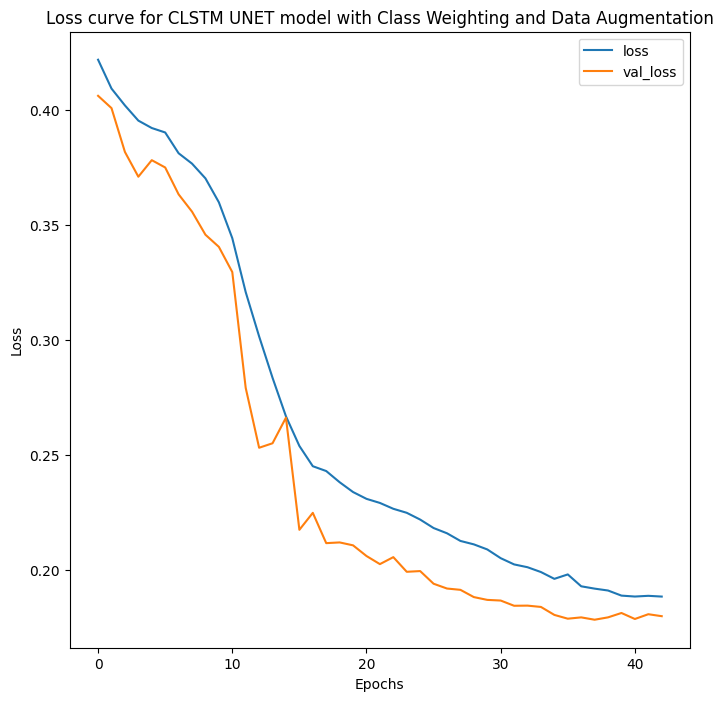

In [ ]:
#30% validation data
plt.figure(figsize=(8, 8))
plt.title("Loss curve for CLSTM UNET model with Class Weighting and Data Augmentation")
plt.plot(history5.history['loss'], label="loss")
plt.plot(history5.history['val_loss'], label="val_loss")
# plt.plot( np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();

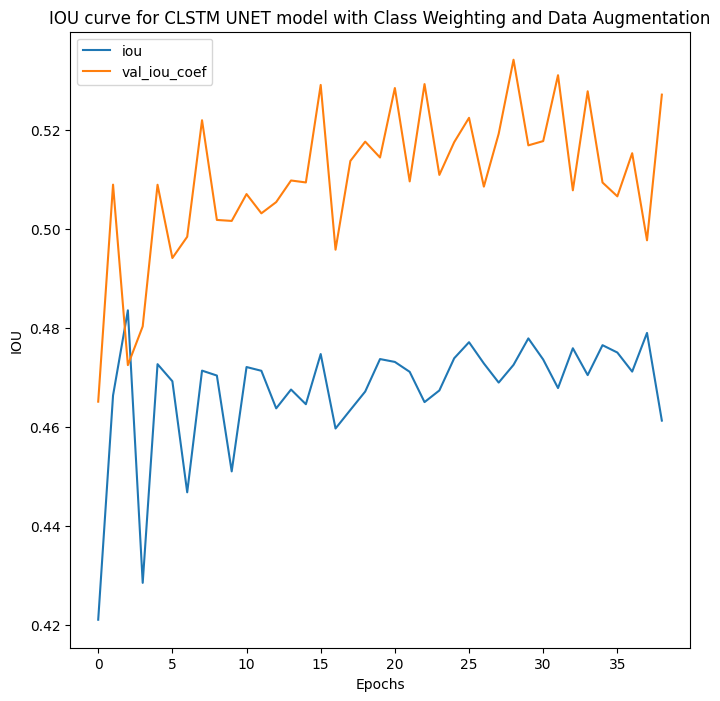

In [ ]:
#30% validation data
plt.figure(figsize=(8, 8))
plt.title("IOU curve for CLSTM UNET model with Class Weighting and Data Augmentation")
plt.plot(history5.history['iou_coef'], label="iou")
plt.plot(history5.history['val_iou_coef'], label="val_iou_coef")
# plt.plot( np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("IOU")
plt.legend();

##Testing

In [ ]:
#testing on 2021 data only, with 3rd iteration and validation data
result = model.evaluate(X_test, y_test)
print(result)

1/1 [==============================] - 0s 220ms/step - loss: 0.1969 - accuracy: 0.8778 - f1_m: 0.9196 - precision_m: 0.8755 - recall_m: 0.9683 - auc: 0.9008 - iou_coef: 0.7430
[0.19687946140766144, 0.8778212070465088, 0.9195846915245056, 0.8755042552947998, 0.9683395028114319, 0.9008119106292725, 0.7430087924003601]


# Loop for getting first 10 data to predict

In [ ]:
from keras.models import load_model
# model = keras.models.load_model("/content/x.h5",  compile=False)#first model with 10 early stopping
# model = keras.models.load_model("/content/gdrive/MyDrive/Crop_Mapping/Final_Data/Models/2nd iteration with 10 early stop instead of 5.h5",  compile=False)#first model with 10 early stopping
# model = keras.models.load_model("/content/gdrive/MyDrive/Crop_Mapping/Final_Data/Models/1st Iteration Model.h5",  compile=False)
# model = keras.models.load_model("/content/gdrive/MyDrive/Crop_Mapping/Final_Data/Models/2nd iteration model.h5",  compile=False)
model_1 = keras.models.load_model("/content/gdrive/MyDrive/Crop_Mapping/Final_Data/Models/2ND Iteration Model with val data.h5",  compile=False)

s2 data 30km2 updated.kml
Data.json
Data.tiff
prediction_patches
incorrect_predictions 0th iteration
images_train_2020
s2_data_path /content/gdrive/MyDrive/Crop_Mapping/Final_Data/2020_30km2_Guj/images_train_2020
x /content/gdrive/MyDrive/Crop_Mapping/Final_Data/2020_30km2_Guj/images_train_2020/image_patch_83
s2_data /content/gdrive/MyDrive/Crop_Mapping/Final_Data/2020_30km2_Guj/images_train_2020/image_patch_83
['2020-11-25.tiff', '2020-11-30.tiff', '2020-12-05.tiff', '2020-12-10.tiff', '2021-01-25.tiff', '2021-01-30.tiff', '2021-02-04.tiff', '2021-02-09.tiff', '2021-03-01.tiff', '2021-03-07.tiff', '2021-04-01.tiff', '2021-04-11.tiff', '2021-04-26.tiff']


  0%|          | 0/13 [00:00<?, ?it/s]

preds (48, 48, 1)
entropy (48, 48, 1)
Final number of superpixels: 144
[0.03715671]
[0.0219177]
[0.02697898]
[0.03566398]
[0.03407881]
[0.08990484]
[0.17855269]
[0.11845974]
[0.05664487]
[0.03594702]
[0.14494222]
[0.10691743]
[0.24134028]
[0.06120252]
[0.04016769]
[0.09798859]
[0.10186904]
[0.2158457]
[0.29055443]
[0.28130832]
[0.29289043]
[0.09407555]
[0.30472565]
[0.10617199]
[0.0519015]
[0.02521558]
[0.0436173]
[0.07055014]
[0.30322245]
[0.29471806]
[0.11478151]
[0.06588987]
[0.28324264]
[0.12654495]
[0.28672111]
[0.32238215]
[0.01838482]
[0.0328505]
[0.06332605]
[0.09573191]
[0.09166411]
[nan]
[0.08040946]
[0.3035087]
[0.05933226]
[0.11522874]
[0.29668251]
[0.15737492]
[0.02860975]
[0.09512017]
[nan]
[0.28370932]
[0.05333602]
[0.04072391]
[0.04069238]
[0.04332934]
[0.03908193]
[0.09020721]
[0.3313337]
[0.09137446]
[0.0257692]
[0.05964507]
[0.28494433]
[0.08066969]
[0.07357274]
[0.0532474]
[0.03666886]
[0.04176622]
[0.04677296]
[0.08476589]
[0.31253549]
[0.14913817]
[0.01965122]
[0.

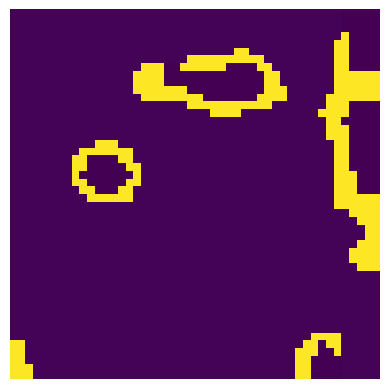

       patch_name  count
0  image_patch_83     21
x /content/gdrive/MyDrive/Crop_Mapping/Final_Data/2020_30km2_Guj/images_train_2020/image_patch_84
s2_data /content/gdrive/MyDrive/Crop_Mapping/Final_Data/2020_30km2_Guj/images_train_2020/image_patch_84
['2020-11-25.tiff', '2020-11-30.tiff', '2020-12-05.tiff', '2020-12-10.tiff', '2021-01-25.tiff', '2021-01-30.tiff', '2021-02-04.tiff', '2021-02-09.tiff', '2021-03-01.tiff', '2021-03-07.tiff', '2021-04-01.tiff', '2021-04-11.tiff', '2021-04-26.tiff']


  0%|          | 0/13 [00:00<?, ?it/s]

preds (48, 48, 1)
entropy (48, 48, 1)
Final number of superpixels: 144
[0.34803987]
[0.05992031]
[0.02903185]
[0.03328373]
[0.04068947]
[0.07160141]
[0.13479026]
[0.12096424]
[0.12899072]
[0.27109334]
[0.29533601]
[0.33925396]
[0.06764333]
[0.03235606]
[0.02468971]
[0.03044756]
[0.04434409]
[nan]
[0.10575293]
[0.13542959]
[0.10562619]
[0.29250428]
[0.09162077]
[0.133435]
[0.0361477]
[0.04279722]
[0.0319607]
[0.0705497]
[nan]
[0.10126192]
[0.11915318]
[0.28336355]
[0.31521672]
[0.09021064]
[0.10158112]
[0.14127541]
[0.06345825]
[0.08742376]
[0.04125609]
[0.04908229]
[0.30266616]
[0.29180419]
[0.14461805]
[0.3021054]
[0.14342177]
[0.30303007]
[0.11337565]
[0.30048454]
[0.30275097]
[0.2246933]
[0.08885693]
[0.07947265]
[0.11917691]
[0.08706858]
[0.09363798]
[0.11198924]
[0.30079854]
[0.08962063]
[0.07768584]
[0.1080511]
[0.28061768]
[0.30858281]
[0.28893906]
[0.29924294]
[0.11864901]
[0.13856071]
[0.12423711]
[0.32001543]
[0.11345494]
[0.07348333]
[0.07773744]
[0.07498077]
[0.32070786]
[0

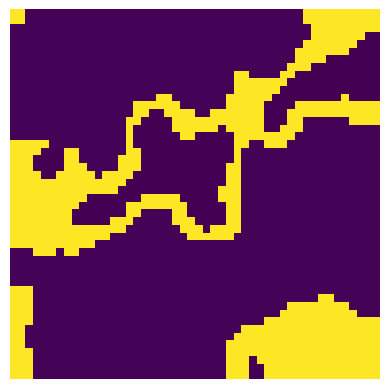

       patch_name  count
0  image_patch_83     21
1  image_patch_84     42
x /content/gdrive/MyDrive/Crop_Mapping/Final_Data/2020_30km2_Guj/images_train_2020/image_patch_85
s2_data /content/gdrive/MyDrive/Crop_Mapping/Final_Data/2020_30km2_Guj/images_train_2020/image_patch_85
['2020-11-25.tiff', '2020-11-30.tiff', '2020-12-05.tiff', '2020-12-10.tiff', '2021-01-25.tiff', '2021-01-30.tiff', '2021-02-04.tiff', '2021-02-09.tiff', '2021-03-01.tiff', '2021-03-07.tiff', '2021-04-01.tiff', '2021-04-11.tiff', '2021-04-26.tiff']


  0%|          | 0/13 [00:00<?, ?it/s]

preds (48, 48, 1)
entropy (48, 48, 1)
Final number of superpixels: 144
[0.29100862]
[0.03493357]
[0.03133968]
[0.02688326]
[0.03009154]
[0.02050916]
[0.05501387]
[0.14818269]
[0.29569796]
[0.327804]
[0.31557277]
[0.28730246]
[0.06846149]
[0.01863416]
[0.02033165]
[0.02010986]
[0.020817]
[0.0148083]
[0.01581544]
[0.05497331]
[0.06912269]
[0.11660291]
[0.12750453]
[0.097436]
[0.02228817]
[0.02419182]
[nan]
[0.02907848]
[0.03484996]
[0.06129265]
[0.06107873]
[0.07141541]
[0.05337768]
[0.06262241]
[0.05431384]
[0.04085613]
[0.01918526]
[0.03963531]
[0.03453724]
[0.09833544]
[0.14182293]
[0.28361863]
[0.17831492]
[0.30759931]
[0.06176728]
[0.02989747]
[0.02661505]
[0.02322853]
[0.02087034]
[0.04428874]
[0.0947517]
[0.29976603]
[0.27651146]
[nan]
[0.11598501]
[0.3082622]
[0.07635172]
[0.02687206]
[0.01765039]
[0.0235167]
[0.02202686]
[0.0471209]
[0.0991978]
[nan]
[0.27633795]
[0.29636994]
[0.13216956]
[0.29566813]
[0.08818725]
[0.03607316]
[0.02174061]
[0.01901521]
[0.02648047]
[0.02262714]


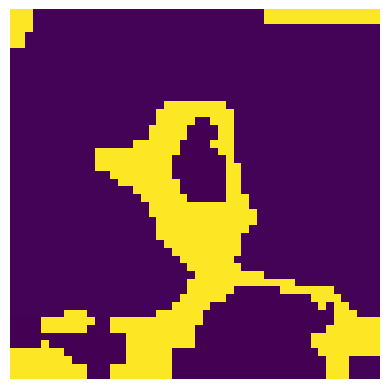

       patch_name  count
0  image_patch_83     21
1  image_patch_84     42
2  image_patch_85     33
x /content/gdrive/MyDrive/Crop_Mapping/Final_Data/2020_30km2_Guj/images_train_2020/image_patch_86
s2_data /content/gdrive/MyDrive/Crop_Mapping/Final_Data/2020_30km2_Guj/images_train_2020/image_patch_86
['2020-11-25.tiff', '2020-11-30.tiff', '2020-12-05.tiff', '2020-12-10.tiff', '2021-01-25.tiff', '2021-01-30.tiff', '2021-02-04.tiff', '2021-02-09.tiff', '2021-03-01.tiff', '2021-03-07.tiff', '2021-04-01.tiff', '2021-04-11.tiff', '2021-04-26.tiff']


  0%|          | 0/13 [00:00<?, ?it/s]

preds (48, 48, 1)
entropy (48, 48, 1)
Final number of superpixels: 144
[0.09801757]
[0.10555173]
[0.18582469]
[0.28441665]
[0.07223502]
[0.28701308]
[0.11384813]
[0.28632158]
[0.34116501]
[0.31239542]
[0.27359423]
[0.05656974]
[0.07875044]
[0.07104266]
[0.28755558]
[0.16321084]
[0.06499816]
[0.28647053]
[0.13561162]
[0.20813149]
[0.26048169]
[0.28338051]
[0.10172474]
[0.02447792]
[0.10256102]
[0.09389201]
[0.29056543]
[0.28251854]
[0.06313377]
[0.08590504]
[0.28009158]
[0.28975171]
[0.24176526]
[0.29699403]
[nan]
[0.06187647]
[0.30507043]
[0.31356424]
[0.12198538]
[0.07018048]
[0.03190612]
[0.05032282]
[0.07966501]
[0.09177764]
[0.04530799]
[0.05762117]
[0.04296264]
[0.02569651]
[0.1263357]
[0.08049787]
[0.11754964]
[0.03301823]
[0.02450733]
[0.06223078]
[0.04460464]
[0.05211035]
[0.07391047]
[0.02372413]
[0.0217392]
[0.04471837]
[0.125431]
[0.08378147]
[0.16283828]
[0.10023788]
[0.04606611]
[0.06068873]
[0.03957698]
[0.04506088]
[0.0493787]
[0.05676977]
[0.02916085]
[0.06342001]
[0.31

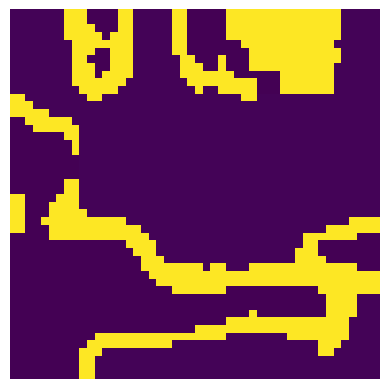

       patch_name  count
0  image_patch_83     21
1  image_patch_84     42
2  image_patch_85     33
3  image_patch_86     37
x /content/gdrive/MyDrive/Crop_Mapping/Final_Data/2020_30km2_Guj/images_train_2020/image_patch_89
s2_data /content/gdrive/MyDrive/Crop_Mapping/Final_Data/2020_30km2_Guj/images_train_2020/image_patch_89
['2020-11-25.tiff', '2020-11-30.tiff', '2020-12-05.tiff', '2020-12-10.tiff', '2021-01-25.tiff', '2021-01-30.tiff', '2021-02-04.tiff', '2021-02-09.tiff', '2021-03-01.tiff', '2021-03-07.tiff', '2021-04-01.tiff', '2021-04-11.tiff', '2021-04-26.tiff']


  0%|          | 0/13 [00:00<?, ?it/s]

preds (48, 48, 1)
entropy (48, 48, 1)
Final number of superpixels: 144
[0.32467502]
[0.216197]
[0.34645119]
[0.08777114]
[0.02599199]
[0.03969274]
[0.06361887]
[0.06299834]
[0.13980399]
[0.28575492]
[0.32558072]
[0.13136166]
[0.28765717]
[0.29772595]
[0.11140134]
[0.03602218]
[0.02143693]
[0.03333443]
[0.03038747]
[0.03088782]
[0.02486124]
[0.09488882]
[0.28120896]
[0.15294473]
[0.09554853]
[0.27164352]
[0.11335457]
[0.03134345]
[0.02471983]
[0.03279009]
[0.02329712]
[0.02970082]
[0.02806452]
[0.05511813]
[0.13600545]
[0.30806842]
[0.02242511]
[0.03379341]
[0.02588961]
[0.01781678]
[0.02677588]
[0.03483521]
[0.07772437]
[0.17725441]
[0.08000913]
[0.03498873]
[0.05164548]
[0.08003566]
[0.01992287]
[0.02224502]
[0.02204796]
[0.02214812]
[0.08220277]
[0.29684359]
[0.360578]
[0.12949516]
[0.30719048]
[0.06177832]
[0.0541195]
[0.03993747]
[0.01492861]
[0.01796954]
[0.02277737]
[0.03210818]
[0.06897269]
[0.04982821]
[0.3143529]
[0.10089163]
[0.30623773]
[0.04760559]
[0.02766518]
[0.02692514]

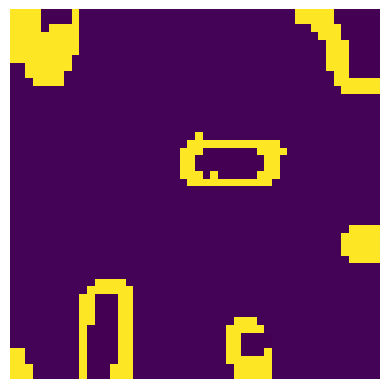

       patch_name  count
0  image_patch_83     21
1  image_patch_84     42
2  image_patch_85     33
3  image_patch_86     37
4  image_patch_89     24
x /content/gdrive/MyDrive/Crop_Mapping/Final_Data/2020_30km2_Guj/images_train_2020/image_patch_90
s2_data /content/gdrive/MyDrive/Crop_Mapping/Final_Data/2020_30km2_Guj/images_train_2020/image_patch_90
['2020-11-25.tiff', '2020-11-30.tiff', '2020-12-05.tiff', '2020-12-10.tiff', '2021-01-25.tiff', '2021-01-30.tiff', '2021-02-04.tiff', '2021-02-09.tiff', '2021-03-01.tiff', '2021-03-07.tiff', '2021-04-01.tiff', '2021-04-11.tiff', '2021-04-26.tiff']


  0%|          | 0/13 [00:00<?, ?it/s]

preds (48, 48, 1)
entropy (48, 48, 1)
Final number of superpixels: 144
[0.28924847]
[0.07213033]
[0.24065031]
[0.32010204]
[0.28864789]
[0.15100612]
[0.11551396]
[0.07465801]
[0.02054616]
[0.01627787]
[0.01774845]
[0.03998115]
[0.04417157]
[0.07052566]
[0.29688224]
[0.28146854]
[0.1825106]
[0.27297151]
[0.27101901]
[0.29223198]
[0.01742768]
[0.01586079]
[0.01440929]
[0.02389796]
[0.0176149]
[0.05442224]
[0.27199605]
[0.17059411]
[0.26917747]
[0.31354585]
[0.28907815]
[0.04587962]
[0.0087609]
[0.01036233]
[0.01570097]
[0.02233403]
[0.02334938]
[0.03909699]
[0.04990727]
[0.29210582]
[0.11402666]
[0.31704777]
[0.06185959]
[0.01607604]
[0.05732819]
[0.05362469]
[0.053535]
[0.03393561]
[0.06932724]
[0.05201088]
[0.0951913]
[0.08640955]
[0.10969184]
[0.30592054]
[0.05778816]
[0.01358009]
[0.05630337]
[0.2834307]
[0.2619558]
[0.03090261]
[0.31486484]
[0.29223689]
[nan]
[nan]
[0.29374]
[0.2735576]
[0.07266718]
[0.03318655]
[0.06849093]
[0.28151828]
[0.11228033]
[0.08116322]
[0.1197748]
[0.0959

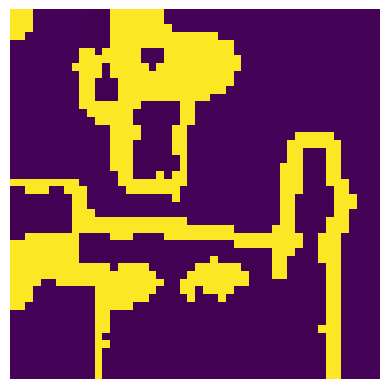

       patch_name  count
0  image_patch_83     21
1  image_patch_84     42
2  image_patch_85     33
3  image_patch_86     37
4  image_patch_89     24
x /content/gdrive/MyDrive/Crop_Mapping/Final_Data/2020_30km2_Guj/images_train_2020/image_patch_93
s2_data /content/gdrive/MyDrive/Crop_Mapping/Final_Data/2020_30km2_Guj/images_train_2020/image_patch_93
['2020-11-25.tiff', '2020-11-30.tiff', '2020-12-05.tiff', '2020-12-10.tiff', '2021-01-25.tiff', '2021-01-30.tiff', '2021-02-04.tiff', '2021-02-09.tiff', '2021-03-01.tiff', '2021-03-07.tiff', '2021-04-01.tiff', '2021-04-11.tiff', '2021-04-26.tiff']


  0%|          | 0/13 [00:00<?, ?it/s]

preds (48, 48, 1)
entropy (48, 48, 1)
Final number of superpixels: 144
[0.34334984]
[0.08489118]
[0.07132483]
[0.15119186]
[0.2730709]
[0.14497456]
[0.12027311]
[0.1762033]
[0.294476]
[0.31985801]
[0.18849973]
[0.28200418]
[0.29790762]
[0.29097164]
[0.2915673]
[0.30191684]
[0.08679062]
[0.30318829]
[0.2872057]
[0.29881936]
[0.08089308]
[0.09604073]
[0.29120979]
[0.29975551]
[0.14328571]
[0.06160429]
[0.11531986]
[0.11048613]
[0.07762823]
[0.06402004]
[0.11766329]
[0.09573897]
[0.04559243]
[0.10048258]
[0.11245155]
[0.16908488]
[0.16534044]
[0.30172011]
[0.08946995]
[0.06036622]
[0.1104974]
[0.11768632]
[0.06882513]
[0.06960957]
[0.08396335]
[0.07120053]
[0.03783857]
[0.04736841]
[0.10813105]
[0.26044503]
[0.07198304]
[0.05634418]
[0.11967605]
[0.08249835]
[0.01360726]
[0.049268]
[0.03919838]
[0.02322267]
[0.02462362]
[0.02844931]
[0.16606316]
[0.29577956]
[0.32336998]
[0.06967367]
[0.13177282]
[0.05705629]
[0.02922001]
[0.01915813]
[0.02083489]
[0.01380588]
[0.02178671]
[0.01600654]
[0

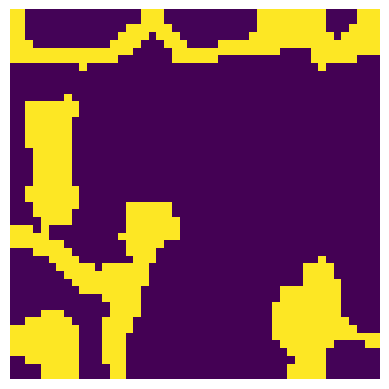

       patch_name  count
0  image_patch_83     21
1  image_patch_84     42
2  image_patch_85     33
3  image_patch_86     37
4  image_patch_89     24
x /content/gdrive/MyDrive/Crop_Mapping/Final_Data/2020_30km2_Guj/images_train_2020/image_patch_94
s2_data /content/gdrive/MyDrive/Crop_Mapping/Final_Data/2020_30km2_Guj/images_train_2020/image_patch_94
['2020-11-25.tiff', '2020-11-30.tiff', '2020-12-05.tiff', '2020-12-10.tiff', '2021-01-25.tiff', '2021-01-30.tiff', '2021-02-04.tiff', '2021-02-09.tiff', '2021-03-01.tiff', '2021-03-07.tiff', '2021-04-01.tiff', '2021-04-11.tiff', '2021-04-26.tiff']


  0%|          | 0/13 [00:00<?, ?it/s]

preds (48, 48, 1)
entropy (48, 48, 1)
Final number of superpixels: 144
[0.11108859]
[0.14095743]
[0.16067858]
[0.14609383]
[nan]
[0.0959629]
[0.05014423]
[0.1506782]
[0.21306519]
[0.31679857]
[0.16045806]
[0.24367104]
[0.1426044]
[0.26348969]
[0.12748729]
[0.08568931]
[0.12420291]
[0.07525291]
[0.03616124]
[0.08903006]
[0.09263554]
[0.28520918]
[0.15103735]
[0.28491288]
[0.1686275]
[0.17586753]
[0.13364288]
[0.09487983]
[0.08507226]
[0.07112915]
[0.09719349]
[0.07383236]
[0.07808854]
[0.10633487]
[0.29682505]
[0.1078056]
[0.30478936]
[0.14460596]
[0.29271603]
[0.29455897]
[0.28911918]
[0.31638062]
[0.10826497]
[0.3011893]
[0.31354457]
[0.05667068]
[0.25501111]
[0.27970952]
[0.12979102]
[0.14487197]
[0.23379326]
[0.30239588]
[0.11965744]
[0.29086876]
[0.06199208]
[0.08187625]
[0.10262182]
[0.13025469]
[0.29233375]
[0.20840968]
[0.09778257]
[0.12930548]
[0.22912018]
[0.24100074]
[0.12577958]
[0.28527319]
[nan]
[0.05239501]
[0.10375806]
[0.1116831]
[nan]
[0.32706285]
[0.14850706]
[0.15381

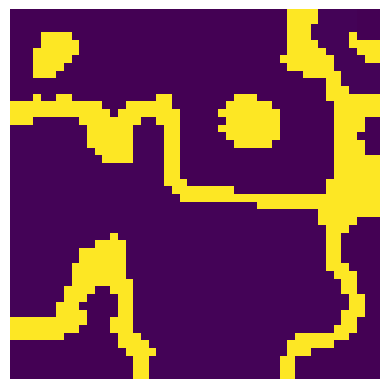

       patch_name  count
0  image_patch_83     21
1  image_patch_84     42
2  image_patch_85     33
3  image_patch_86     37
4  image_patch_89     24
x /content/gdrive/MyDrive/Crop_Mapping/Final_Data/2020_30km2_Guj/images_train_2020/image_patch_95
s2_data /content/gdrive/MyDrive/Crop_Mapping/Final_Data/2020_30km2_Guj/images_train_2020/image_patch_95
['2020-11-25.tiff', '2020-11-30.tiff', '2020-12-05.tiff', '2020-12-10.tiff', '2021-01-25.tiff', '2021-01-30.tiff', '2021-02-04.tiff', '2021-02-09.tiff', '2021-03-01.tiff', '2021-03-07.tiff', '2021-04-01.tiff', '2021-04-11.tiff', '2021-04-26.tiff']


  0%|          | 0/13 [00:00<?, ?it/s]

preds (48, 48, 1)
entropy (48, 48, 1)
Final number of superpixels: 144
[0.09805639]
[0.29245627]
[0.15781596]
[0.35251749]
[0.0650904]
[0.02508438]
[0.02593447]
[0.02219796]
[0.0625461]
[0.31187764]
[0.11111779]
[0.14041753]
[0.06467016]
[0.09632684]
[0.12942675]
[0.28122696]
[0.03990525]
[0.02421259]
[0.02090465]
[0.06861997]
[0.29711273]
[0.08638681]
[0.13657828]
[0.3051236]
[0.03116741]
[0.07613742]
[0.32033762]
[0.2993536]
[0.04590072]
[0.08592263]
[0.03892719]
[0.06657388]
[0.30381203]
[0.17271584]
[0.298769]
[0.27294788]
[0.02898378]
[0.02814049]
[0.04778275]
[0.05952426]
[0.30364558]
[0.07660209]
[0.08780317]
[0.31002292]
[0.12780356]
[0.24193437]
[0.27812865]
[0.1223284]
[0.01753768]
[0.0244029]
[0.02408429]
[0.02568023]
[0.15831694]
[0.29073837]
[0.28838021]
[0.10960594]
[0.13666822]
[0.25495526]
[0.12702185]
[0.09579554]
[0.01684313]
[0.02436899]
[0.02020407]
[0.05084149]
[0.23374452]
[0.29192606]
[0.3216804]
[0.14187329]
[0.126838]
[0.11812238]
[0.09632512]
[0.10123536]
[0.0

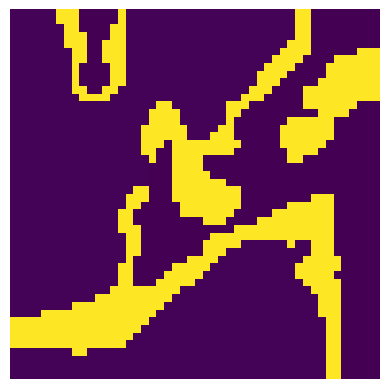

       patch_name  count
0  image_patch_83     21
1  image_patch_84     42
2  image_patch_85     33
3  image_patch_86     37
4  image_patch_89     24
x /content/gdrive/MyDrive/Crop_Mapping/Final_Data/2020_30km2_Guj/images_train_2020/image_patch_96
s2_data /content/gdrive/MyDrive/Crop_Mapping/Final_Data/2020_30km2_Guj/images_train_2020/image_patch_96
['2020-11-25.tiff', '2020-11-30.tiff', '2020-12-05.tiff', '2020-12-10.tiff', '2021-01-25.tiff', '2021-01-30.tiff', '2021-02-04.tiff', '2021-02-09.tiff', '2021-03-01.tiff', '2021-03-07.tiff', '2021-04-01.tiff', '2021-04-11.tiff', '2021-04-26.tiff']


  0%|          | 0/13 [00:00<?, ?it/s]

preds (48, 48, 1)
entropy (48, 48, 1)
Final number of superpixels: 144
[0.02798758]
[0.02509923]
[0.02830226]
[0.02497546]
[0.02313625]
[0.02718168]
[0.03047735]
[0.02643549]
[0.03827682]
[0.0527867]
[0.23377064]
[0.32226574]
[0.01621142]
[0.01798259]
[0.01941675]
[0.01732978]
[0.01427422]
[0.04565379]
[0.02531489]
[0.03819564]
[0.03890904]
[0.07092115]
[0.29157701]
[0.09074122]
[0.02038983]
[0.03266597]
[0.02142438]
[0.03123238]
[0.08261735]
[0.29794309]
[0.09032973]
[0.09471849]
[0.30291677]
[0.10909452]
[0.29748383]
[nan]
[0.03750458]
[0.06946172]
[0.05440618]
[0.0858357]
[0.27087256]
[0.1269287]
[0.2850877]
[0.11266354]
[0.08784766]
[0.30674833]
[0.10803559]
[0.31269628]
[0.06630637]
[0.06436501]
[0.07946023]
[0.30062568]
[0.12605731]
[0.2848514]
[0.31757921]
[0.07729745]
[0.07610711]
[0.03745703]
[0.09794696]
[0.21999729]
[0.06680098]
[0.07711618]
[0.08802221]
[0.28003609]
[0.05165068]
[0.2795783]
[0.07276858]
[0.29571113]
[0.12255078]
[0.30042076]
[0.07856939]
[0.31542212]
[0.088

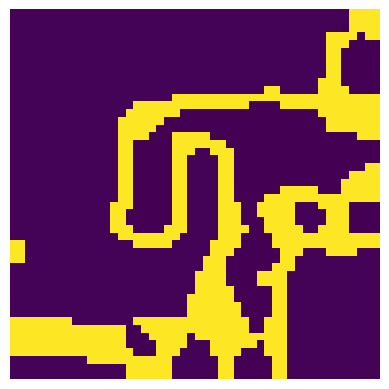

       patch_name  count
0  image_patch_83     21
1  image_patch_84     42
2  image_patch_85     33
3  image_patch_86     37
4  image_patch_89     24
x /content/gdrive/MyDrive/Crop_Mapping/Final_Data/2020_30km2_Guj/images_train_2020/image_patch_99
s2_data /content/gdrive/MyDrive/Crop_Mapping/Final_Data/2020_30km2_Guj/images_train_2020/image_patch_99
['2020-11-25.tiff', '2020-11-30.tiff', '2020-12-05.tiff', '2020-12-10.tiff', '2021-01-25.tiff', '2021-01-30.tiff', '2021-02-04.tiff', '2021-02-09.tiff', '2021-03-01.tiff', '2021-03-07.tiff', '2021-04-01.tiff', '2021-04-11.tiff', '2021-04-26.tiff']


  0%|          | 0/13 [00:00<?, ?it/s]

preds (48, 48, 1)
entropy (48, 48, 1)
Final number of superpixels: 144
[0.31583339]
[0.09829209]
[0.06040947]
[0.30410305]
[0.09057764]
[0.1314826]
[0.09028621]
[0.30601412]
[0.30402556]
[0.16300507]
[0.31829336]
[0.22365545]
[0.31315184]
[0.08454281]
[0.0646829]
[0.30537152]
[0.12799568]
[0.2972399]
[0.1049147]
[0.31823516]
[0.29977894]
[0.08374223]
[0.28928986]
[0.09761077]
[0.11909864]
[0.04663031]
[0.07015038]
[0.27447188]
[0.10831578]
[nan]
[0.1099938]
[0.31373158]
[0.13240756]
[0.07383327]
[0.26270905]
[0.1010689]
[0.04240442]
[0.08299565]
[0.09188563]
[0.32496646]
[0.34012336]
[0.27491158]
[0.13454261]
[0.30694839]
[0.09088133]
[0.30360618]
[0.30755302]
[0.10658932]
[0.06994587]
[0.30039474]
[0.09113328]
[0.30746621]
[0.11132275]
[0.29234183]
[0.11308527]
[0.09109098]
[0.2936101]
[0.08307684]
[nan]
[0.098673]
[0.06664142]
[0.29449302]
[0.0771916]
[0.27578688]
[0.32001618]
[0.3180581]
[0.28300831]
[0.10120889]
[0.31726485]
[0.31883043]
[0.07671664]
[0.28120938]
[0.07661864]
[0.06

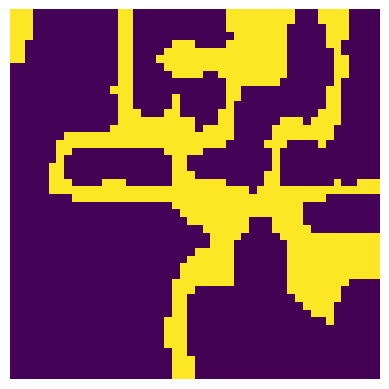

       patch_name  count
0  image_patch_83     21
1  image_patch_84     42
2  image_patch_85     33
3  image_patch_86     37
4  image_patch_89     24
x /content/gdrive/MyDrive/Crop_Mapping/Final_Data/2020_30km2_Guj/images_train_2020/image_patch_100
s2_data /content/gdrive/MyDrive/Crop_Mapping/Final_Data/2020_30km2_Guj/images_train_2020/image_patch_100
['2020-11-25.tiff', '2020-11-30.tiff', '2020-12-05.tiff', '2020-12-10.tiff', '2021-01-25.tiff', '2021-01-30.tiff', '2021-02-04.tiff', '2021-02-09.tiff', '2021-03-01.tiff', '2021-03-07.tiff', '2021-04-01.tiff', '2021-04-11.tiff', '2021-04-26.tiff']


  0%|          | 0/13 [00:00<?, ?it/s]

preds (48, 48, 1)
entropy (48, 48, 1)
Final number of superpixels: 144
[0.0852192]
[0.08086582]
[0.05381737]
[0.04383901]
[0.03220564]
[0.04286391]
[0.08988845]
[0.31223062]
[nan]
[0.14380942]
[0.03449966]
[0.03541188]
[0.0418077]
[0.07103874]
[0.07353424]
[0.03951656]
[0.07343794]
[0.08247158]
[0.31457984]
[0.12273933]
[0.12027329]
[0.0153175]
[0.00880523]
[0.00640947]
[0.30224323]
[0.30360308]
[0.1156314]
[0.10726769]
[0.09330378]
[0.08227045]
[nan]
[0.28934184]
[0.0820115]
[0.1130933]
[0.01998009]
[0.0112332]
[nan]
[0.11262316]
[0.30559257]
[0.11483203]
[0.09461721]
[0.13980836]
[0.29570228]
[0.08915925]
[0.0209957]
[0.01867614]
[0.00901405]
[0.00594586]
[0.10751056]
[0.16106603]
[0.27958819]
[0.28702372]
[0.26685688]
[0.28473529]
[0.12619352]
[0.10169746]
[0.03600571]
[0.01319481]
[0.00916314]
[0.02089429]
[0.29985735]
[0.29573724]
[0.31099734]
[0.16401985]
[0.2886278]
[0.16328314]
[0.15450087]
[0.14414597]
[0.10184897]
[0.02814588]
[0.03286695]
[0.01924234]
[0.10760361]
[nan]
[0.2

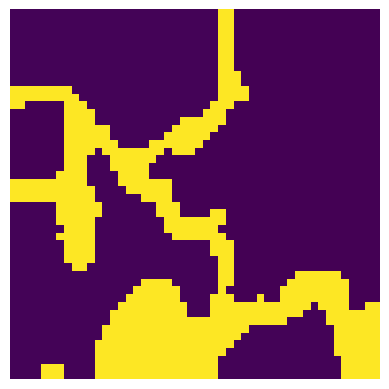

       patch_name  count
0  image_patch_83     21
1  image_patch_84     42
2  image_patch_85     33
3  image_patch_86     37
4  image_patch_89     24
x /content/gdrive/MyDrive/Crop_Mapping/Final_Data/2020_30km2_Guj/images_train_2020/image_patch_101
s2_data /content/gdrive/MyDrive/Crop_Mapping/Final_Data/2020_30km2_Guj/images_train_2020/image_patch_101
['2020-11-25.tiff', '2020-11-30.tiff', '2020-12-05.tiff', '2020-12-10.tiff', '2021-01-25.tiff', '2021-01-30.tiff', '2021-02-04.tiff', '2021-02-09.tiff', '2021-03-01.tiff', '2021-03-07.tiff', '2021-04-01.tiff', '2021-04-11.tiff', '2021-04-26.tiff']


  0%|          | 0/13 [00:00<?, ?it/s]

preds (48, 48, 1)
entropy (48, 48, 1)
Final number of superpixels: 144
[0.14765692]
[0.07791985]
[0.09221757]
[0.2183623]
[0.11065366]
[0.30536294]
[0.08631743]
[0.06110225]
[0.30465192]
[0.1018072]
[0.28976354]
[0.26533291]
[0.14731601]
[0.14711432]
[0.10735738]
[0.30308101]
[0.15517108]
[0.30589506]
[nan]
[0.08491492]
[0.12172446]
[0.08577694]
[0.27869657]
[0.13990955]
[0.14891776]
[0.10352338]
[0.12778574]
[0.29126382]
[0.32459959]
[0.29849467]
[0.27289164]
[0.12688038]
[nan]
[0.29075453]
[0.29436702]
[0.10834495]
[0.21724126]
[0.15014842]
[0.08780476]
[0.08897337]
[0.31385684]
[0.27478284]
[0.17560947]
[0.17194863]
[0.26553586]
[0.1019484]
[0.27688485]
[0.23532455]
[0.15147151]
[0.11024521]
[0.05773665]
[0.0931964]
[0.09661628]
[0.29009131]
[0.16502969]
[0.30997759]
[0.29168284]
[0.11685307]
[0.28377712]
[0.10511693]
[0.08176372]
[0.07630415]
[0.04690946]
[0.02928746]
[0.05074927]
[0.14884885]
[0.27044451]
[0.34041554]
[nan]
[0.26854426]
[0.2901915]
[0.16139753]
[0.06349415]
[0.068

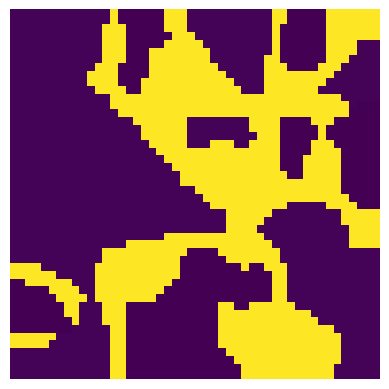

       patch_name  count
0  image_patch_83     21
1  image_patch_84     42
2  image_patch_85     33
3  image_patch_86     37
4  image_patch_89     24
x /content/gdrive/MyDrive/Crop_Mapping/Final_Data/2020_30km2_Guj/images_train_2020/image_patch_102
s2_data /content/gdrive/MyDrive/Crop_Mapping/Final_Data/2020_30km2_Guj/images_train_2020/image_patch_102
['2020-11-25.tiff', '2020-11-30.tiff', '2020-12-05.tiff', '2020-12-10.tiff', '2021-01-25.tiff', '2021-01-30.tiff', '2021-02-04.tiff', '2021-02-09.tiff', '2021-03-01.tiff', '2021-03-07.tiff', '2021-04-01.tiff', '2021-04-11.tiff', '2021-04-26.tiff']


  0%|          | 0/13 [00:00<?, ?it/s]

preds (48, 48, 1)
entropy (48, 48, 1)
Final number of superpixels: 144
[0.10288068]
[0.11147328]
[nan]
[0.13460647]
[0.11772595]
[0.29054981]
[0.30259734]
[0.30034027]
[0.26677424]
[0.33263472]
[nan]
[0.08533741]
[0.10027304]
[0.11343464]
[0.12012711]
[0.09427143]
[0.1256514]
[0.28507212]
[0.11080101]
[0.0958555]
[0.31767803]
[0.32069525]
[0.09905672]
[0.03823272]
[0.11815576]
[0.09375586]
[0.09001318]
[0.15296718]
[0.14884357]
[0.28631675]
[nan]
[0.12555616]
[0.30210048]
[0.31109616]
[nan]
[0.09515919]
[0.10214188]
[0.14193444]
[0.11067223]
[0.17143553]
[0.17467034]
[0.18412872]
[0.28041124]
[0.13369603]
[0.28292045]
[0.33219561]
[nan]
[0.30743501]
[0.07073272]
[0.095488]
[0.0736696]
[0.08743838]
[0.10320389]
[0.14217472]
[0.12264784]
[0.15099175]
[0.31301406]
[0.33311555]
[0.17563772]
[0.29020107]
[0.1108692]
[0.20340574]
[0.06237444]
[0.08059217]
[0.04225836]
[0.06803431]
[0.09891809]
[0.14100327]
[0.29623067]
[0.29439697]
[nan]
[0.25803006]
[0.09280215]
[0.22539386]
[0.09566759]
[0

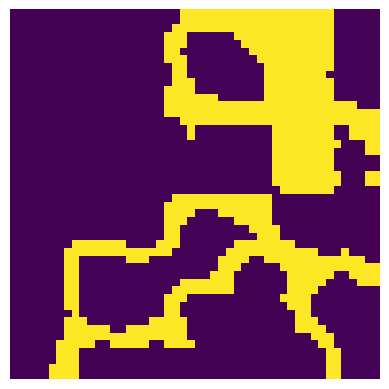

       patch_name  count
0  image_patch_83     21
1  image_patch_84     42
2  image_patch_85     33
3  image_patch_86     37
4  image_patch_89     24
x /content/gdrive/MyDrive/Crop_Mapping/Final_Data/2020_30km2_Guj/images_train_2020/image_patch_107
s2_data /content/gdrive/MyDrive/Crop_Mapping/Final_Data/2020_30km2_Guj/images_train_2020/image_patch_107
['2020-11-25.tiff', '2020-11-30.tiff', '2020-12-05.tiff', '2020-12-10.tiff', '2021-01-25.tiff', '2021-01-30.tiff', '2021-02-04.tiff', '2021-02-09.tiff', '2021-03-01.tiff', '2021-03-07.tiff', '2021-04-01.tiff', '2021-04-11.tiff', '2021-04-26.tiff']


  0%|          | 0/13 [00:00<?, ?it/s]

preds (48, 48, 1)
entropy (48, 48, 1)
Final number of superpixels: 144
[0.14487775]
[0.09162912]
[0.1048447]
[0.12895337]
[nan]
[0.09622474]
[0.14238319]
[0.29893899]
[0.24499607]
[0.1668698]
[0.2969256]
[0.11969199]
[0.02618791]
[0.23023619]
[0.19592449]
[0.2900767]
[0.10332032]
[0.08413554]
[0.1024667]
[0.17293724]
[0.26568237]
[0.29964077]
[nan]
[0.07061137]
[0.01765359]
[0.00329777]
[0.0334141]
[nan]
[0.1098848]
[0.09411988]
[0.10574323]
[0.20907538]
[0.13613668]
[0.08677734]
[0.0827851]
[0.03550141]
[0.01913275]
[0.00363181]
[0.01373672]
[0.27918825]
[0.10370862]
[0.06886367]
[0.05361909]
[nan]
[0.09435497]
[0.0549064]
[0.02617929]
[0.03256313]
[0.00909548]
[0.00485099]
[0.00960792]
[0.27069113]
[0.09151353]
[0.0519607]
[0.04044564]
[0.02975287]
[0.04462578]
[0.02853161]
[0.02569244]
[0.02664186]
[0.09173016]
[0.0409186]
[0.04328856]
[0.29743004]
[0.0734195]
[0.05062817]
[0.04550375]
[0.04969994]
[0.0460931]
[0.02814291]
[0.03108652]
[0.02563304]
[0.29398137]
[0.29445663]
[0.29405

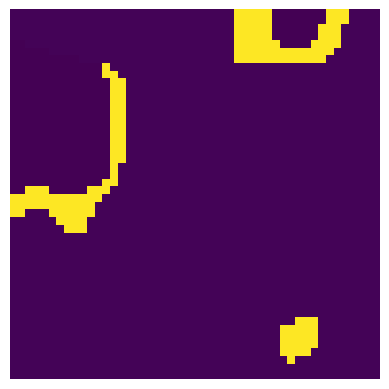

       patch_name  count
0  image_patch_83     21
1  image_patch_84     42
2  image_patch_85     33
3  image_patch_86     37
4  image_patch_89     24
x /content/gdrive/MyDrive/Crop_Mapping/Final_Data/2020_30km2_Guj/images_train_2020/image_patch_108
s2_data /content/gdrive/MyDrive/Crop_Mapping/Final_Data/2020_30km2_Guj/images_train_2020/image_patch_108
['2020-11-25.tiff', '2020-11-30.tiff', '2020-12-05.tiff', '2020-12-10.tiff', '2021-01-25.tiff', '2021-01-30.tiff', '2021-02-04.tiff', '2021-02-09.tiff', '2021-03-01.tiff', '2021-03-07.tiff', '2021-04-01.tiff', '2021-04-11.tiff', '2021-04-26.tiff']


  0%|          | 0/13 [00:00<?, ?it/s]

preds (48, 48, 1)
entropy (48, 48, 1)
Final number of superpixels: 144
[0.02342951]
[0.05115699]
[0.04489139]
[0.05371035]
[0.07796569]
[0.30928633]
[0.31371537]
[0.14676897]
[0.07475518]
[0.05416524]
[0.03585638]
[0.03703116]
[0.04459815]
[0.02440722]
[0.25864336]
[0.10429931]
[0.27415228]
[0.10451603]
[0.30703202]
[0.33121264]
[0.29765561]
[0.05694148]
[0.03117135]
[0.03289754]
[0.31791225]
[0.10660125]
[0.30463603]
[0.28906846]
[0.26519179]
[0.14131323]
[0.33487952]
[0.36536312]
[0.28762347]
[0.06606411]
[0.078179]
[0.04012612]
[0.11899967]
[0.07958216]
[0.31224862]
[0.07699785]
[0.1264995]
[0.10245588]
[0.11528487]
[0.33971733]
[0.0816712]
[0.13789164]
[0.10446613]
[0.05602411]
[0.29094046]
[0.28570169]
[0.30327207]
[0.03887403]
[0.12000885]
[0.04673018]
[0.30533174]
[0.07354175]
[0.05989558]
[0.07413966]
[0.08112804]
[0.03868446]
[0.03970625]
[0.03213824]
[0.05791933]
[0.29927766]
[0.08711635]
[0.05262405]
[0.07830065]
[0.22635427]
[0.2910254]
[0.06888624]
[0.28704211]
[0.09170903

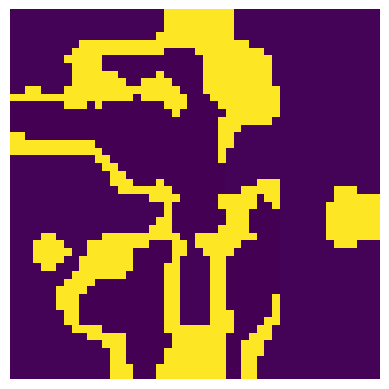

       patch_name  count
0  image_patch_83     21
1  image_patch_84     42
2  image_patch_85     33
3  image_patch_86     37
4  image_patch_89     24
x /content/gdrive/MyDrive/Crop_Mapping/Final_Data/2020_30km2_Guj/images_train_2020/image_patch_109
s2_data /content/gdrive/MyDrive/Crop_Mapping/Final_Data/2020_30km2_Guj/images_train_2020/image_patch_109
['2020-11-25.tiff', '2020-11-30.tiff', '2020-12-05.tiff', '2020-12-10.tiff', '2021-01-25.tiff', '2021-01-30.tiff', '2021-02-04.tiff', '2021-02-09.tiff', '2021-03-01.tiff', '2021-03-07.tiff', '2021-04-01.tiff', '2021-04-11.tiff', '2021-04-26.tiff']


  0%|          | 0/13 [00:00<?, ?it/s]

preds (48, 48, 1)
entropy (48, 48, 1)
Final number of superpixels: 144
[0.32192224]
[0.12697648]
[0.0970829]
[0.06957426]
[0.07732271]
[0.06470368]
[0.05425792]
[0.0756246]
[0.10541644]
[0.32971802]
[nan]
[0.06070368]
[0.26781341]
[0.29332373]
[0.33491531]
[0.29064524]
[nan]
[0.10342846]
[0.09169268]
[0.2844573]
[0.30574405]
[0.29335481]
[0.06679913]
[0.02746046]
[0.24619062]
[0.12767434]
[0.32000858]
[0.30079955]
[0.11466109]
[0.30198836]
[0.30272385]
[0.11041411]
[0.31578368]
[0.30559972]
[0.0865868]
[0.02154773]
[0.3157919]
[0.15208489]
[0.30316669]
[0.30175838]
[0.31268933]
[0.09076474]
[0.15415619]
[0.10847697]
[0.32693234]
[0.32169935]
[0.10820972]
[0.02987028]
[0.23655638]
[0.05106413]
[0.0217852]
[0.10795769]
[0.10208823]
[0.31444031]
[0.29753363]
[0.292649]
[0.33908147]
[0.30403283]
[nan]
[0.09503619]
[0.05934955]
[0.02127098]
[0.01724354]
[0.01816157]
[0.05513705]
[nan]
[0.31928366]
[0.32094473]
[nan]
[0.11412511]
[nan]
[0.32612205]
[0.04005139]
[0.07600314]
[0.01692431]
[0.0

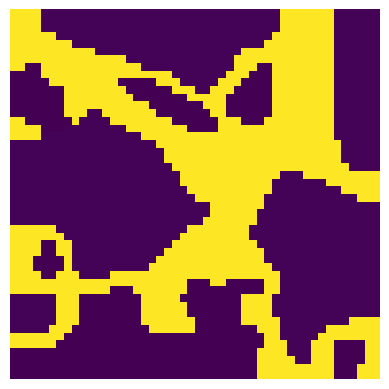

       patch_name  count
0  image_patch_83     21
1  image_patch_84     42
2  image_patch_85     33
3  image_patch_86     37
4  image_patch_89     24
x /content/gdrive/MyDrive/Crop_Mapping/Final_Data/2020_30km2_Guj/images_train_2020/image_patch_110
s2_data /content/gdrive/MyDrive/Crop_Mapping/Final_Data/2020_30km2_Guj/images_train_2020/image_patch_110
['2020-11-25.tiff', '2020-11-30.tiff', '2020-12-05.tiff', '2020-12-10.tiff', '2021-01-25.tiff', '2021-01-30.tiff', '2021-02-04.tiff', '2021-02-09.tiff', '2021-03-01.tiff', '2021-03-07.tiff', '2021-04-01.tiff', '2021-04-11.tiff', '2021-04-26.tiff']


  0%|          | 0/13 [00:00<?, ?it/s]

preds (48, 48, 1)
entropy (48, 48, 1)
Final number of superpixels: 144
[0.02499218]
[0.04415764]
[0.30939171]
[0.08376439]
[0.07712805]
[0.29971984]
[0.14130461]
[0.08385967]
[0.10100236]
[0.08693965]
[0.33017391]
[0.06942525]
[0.00334417]
[0.02916029]
[0.31489372]
[0.07674038]
[0.06142504]
[0.29517463]
[0.30206653]
[0.08477604]
[0.29057398]
[0.29125774]
[0.04200506]
[0.01964844]
[0.00549343]
[0.02101282]
[0.09227447]
[0.32354495]
[0.08933052]
[0.28859326]
[0.0773287]
[0.29112619]
[0.0736479]
[0.04194108]
[0.0120177]
[0.01892412]
[0.00979441]
[0.03578626]
[0.01773264]
[0.06136661]
[0.11033356]
[nan]
[0.03797777]
[0.03773043]
[0.01353764]
[0.01261022]
[0.01175376]
[0.01724814]
[0.01608219]
[0.07683682]
[0.05561406]
[0.02080448]
[0.09055724]
[0.28795868]
[0.01097699]
[0.00930357]
[0.01571521]
[0.01287894]
[0.00912988]
[0.02149441]
[0.01299314]
[0.06265613]
[0.09591191]
[0.10101162]
[0.34465951]
[0.27683735]
[0.06692866]
[0.04026286]
[0.0443538]
[0.10026041]
[0.01548552]
[0.02145587]
[0.0

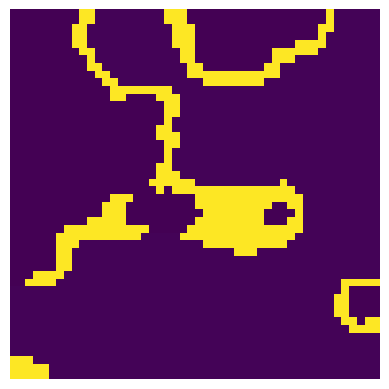

       patch_name  count
0  image_patch_83     21
1  image_patch_84     42
2  image_patch_85     33
3  image_patch_86     37
4  image_patch_89     24
x /content/gdrive/MyDrive/Crop_Mapping/Final_Data/2020_30km2_Guj/images_train_2020/image_patch_111
s2_data /content/gdrive/MyDrive/Crop_Mapping/Final_Data/2020_30km2_Guj/images_train_2020/image_patch_111
['2020-11-25.tiff', '2020-11-30.tiff', '2020-12-05.tiff', '2020-12-10.tiff', '2021-01-25.tiff', '2021-01-30.tiff', '2021-02-04.tiff', '2021-02-09.tiff', '2021-03-01.tiff', '2021-03-07.tiff', '2021-04-01.tiff', '2021-04-11.tiff', '2021-04-26.tiff']


  0%|          | 0/13 [00:00<?, ?it/s]

preds (48, 48, 1)
entropy (48, 48, 1)
Final number of superpixels: 144
[0.10173273]
[0.10102475]
[0.12659299]
[0.33483145]
[0.12243997]
[0.29591787]
[nan]
[0.10424902]
[0.08827871]
[0.09651089]
[0.08467888]
[0.11723283]
[0.10491882]
[0.30380428]
[0.28801793]
[0.30416688]
[0.09142274]
[0.30440077]
[0.28774136]
[0.08112393]
[0.05342247]
[0.05978961]
[0.05896143]
[0.04731479]
[0.05849703]
[0.30620763]
[0.10164443]
[0.11175363]
[0.26567492]
[0.1489822]
[0.30619541]
[0.09990798]
[0.06638746]
[0.06131846]
[0.06798422]
[0.09215711]
[0.07835982]
[0.28293204]
[0.13005313]
[0.13621992]
[0.13967329]
[0.26811469]
[0.08420884]
[0.06316942]
[0.07453783]
[0.08233082]
[0.06527334]
[0.09506608]
[0.05898672]
[0.30485958]
[0.12184554]
[0.2717143]
[0.27553791]
[0.28995708]
[0.08329463]
[0.03348462]
[0.03330698]
[0.04079853]
[0.04831938]
[0.05984604]
[0.05625846]
[0.08577274]
[0.07205581]
[0.32160988]
[0.09139629]
[0.0607866]
[0.03065486]
[0.02579592]
[0.03539276]
[0.05562292]
[0.06212786]
[0.08740924]
[0.

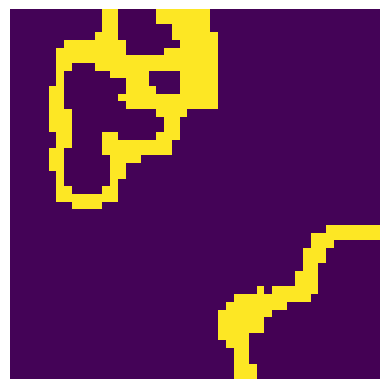

       patch_name  count
0  image_patch_83     21
1  image_patch_84     42
2  image_patch_85     33
3  image_patch_86     37
4  image_patch_89     24
x /content/gdrive/MyDrive/Crop_Mapping/Final_Data/2020_30km2_Guj/images_train_2020/image_patch_112
s2_data /content/gdrive/MyDrive/Crop_Mapping/Final_Data/2020_30km2_Guj/images_train_2020/image_patch_112
['2020-11-25.tiff', '2020-11-30.tiff', '2020-12-05.tiff', '2020-12-10.tiff', '2021-01-25.tiff', '2021-01-30.tiff', '2021-02-04.tiff', '2021-02-09.tiff', '2021-03-01.tiff', '2021-03-07.tiff', '2021-04-01.tiff', '2021-04-11.tiff', '2021-04-26.tiff']


  0%|          | 0/13 [00:00<?, ?it/s]

preds (48, 48, 1)
entropy (48, 48, 1)
Final number of superpixels: 144
[0.03465577]
[0.02972659]
[0.02901773]
[0.06501441]
[0.07039895]
[0.082098]
[0.1363208]
[0.27048415]
[0.30726489]
[0.28759816]
[0.13800289]
[0.29520574]
[0.0288214]
[0.03121722]
[0.03829778]
[0.04840466]
[0.07939033]
[0.12630738]
[0.14463013]
[0.1388953]
[0.085307]
[0.12270598]
[0.17280048]
[0.30366626]
[0.02815086]
[0.03963419]
[0.04965398]
[0.11858058]
[0.3178626]
[0.10693465]
[0.09888964]
[0.27664444]
[0.07226712]
[0.08552944]
[0.18397433]
[0.15032509]
[0.05220928]
[0.10045073]
[0.11168043]
[0.29368034]
[0.09832939]
[0.0927136]
[0.10325878]
[0.30076191]
[0.09640828]
[0.07159569]
[0.1283282]
[nan]
[0.31325799]
[nan]
[0.29676729]
[0.06880143]
[nan]
[0.25225785]
[0.28653255]
[0.06681919]
[0.29164261]
[0.06496775]
[0.28829312]
[0.3091754]
[0.15401442]
[0.25101727]
[0.12733296]
[0.07957404]
[0.07542965]
[0.29469803]
[0.32783365]
[0.06521291]
[0.09331821]
[0.17710525]
[0.27831787]
[0.12221143]
[0.26747614]
[0.30627659]

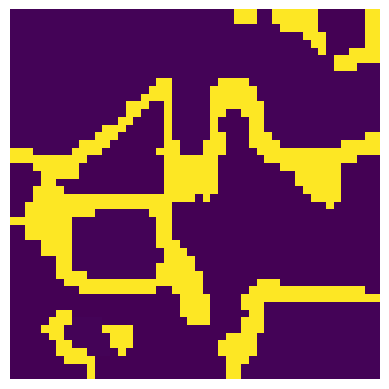

       patch_name  count
0  image_patch_83     21
1  image_patch_84     42
2  image_patch_85     33
3  image_patch_86     37
4  image_patch_89     24
x /content/gdrive/MyDrive/Crop_Mapping/Final_Data/2020_30km2_Guj/images_train_2020/image_patch_117
s2_data /content/gdrive/MyDrive/Crop_Mapping/Final_Data/2020_30km2_Guj/images_train_2020/image_patch_117
['2020-11-25.tiff', '2020-11-30.tiff', '2020-12-05.tiff', '2020-12-10.tiff', '2021-01-25.tiff', '2021-01-30.tiff', '2021-02-04.tiff', '2021-02-09.tiff', '2021-03-01.tiff', '2021-03-07.tiff', '2021-04-01.tiff', '2021-04-11.tiff', '2021-04-26.tiff']


  0%|          | 0/13 [00:00<?, ?it/s]

preds (48, 48, 1)
entropy (48, 48, 1)
Final number of superpixels: 144
[0.11228435]
[0.33532834]
[0.2892676]
[0.14075029]
[0.07764143]
[0.10787296]
[0.28628883]
[0.06413831]
[0.06112045]
[0.09964776]
[0.12058076]
[0.14437018]
[0.08742088]
[0.28444266]
[0.30751029]
[0.31916922]
[0.30603272]
[0.09394139]
[0.29427627]
[0.09043081]
[0.09295563]
[0.12262262]
[0.28848115]
[0.15906507]
[0.08481668]
[0.25712094]
[nan]
[0.17969885]
[0.26649216]
[0.3073906]
[0.14171079]
[0.16990602]
[nan]
[0.23959306]
[0.2771576]
[0.32696819]
[0.07331684]
[0.30083477]
[0.13184361]
[0.30536833]
[0.16009624]
[0.28028634]
[0.25868031]
[0.23370853]
[0.13632438]
[0.13698572]
[0.27336854]
[0.28813025]
[0.05370558]
[0.12223523]
[0.16566792]
[0.29337683]
[0.10692269]
[0.121226]
[0.1048694]
[0.26537356]
[0.13525212]
[0.1011669]
[0.29146868]
[0.20752349]
[0.03137156]
[0.10632189]
[0.28792593]
[0.31392798]
[nan]
[0.09180802]
[0.07451811]
[0.08017085]
[0.09467388]
[0.11267924]
[0.27926928]
[0.28793547]
[0.01779703]
[0.04921

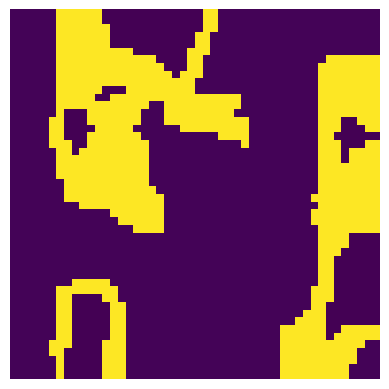

       patch_name  count
0  image_patch_83     21
1  image_patch_84     42
2  image_patch_85     33
3  image_patch_86     37
4  image_patch_89     24
x /content/gdrive/MyDrive/Crop_Mapping/Final_Data/2020_30km2_Guj/images_train_2020/image_patch_118
s2_data /content/gdrive/MyDrive/Crop_Mapping/Final_Data/2020_30km2_Guj/images_train_2020/image_patch_118
['2020-11-25.tiff', '2020-11-30.tiff', '2020-12-05.tiff', '2020-12-10.tiff', '2021-01-25.tiff', '2021-01-30.tiff', '2021-02-04.tiff', '2021-02-09.tiff', '2021-03-01.tiff', '2021-03-07.tiff', '2021-04-01.tiff', '2021-04-11.tiff', '2021-04-26.tiff']


  0%|          | 0/13 [00:00<?, ?it/s]

preds (48, 48, 1)
entropy (48, 48, 1)
Final number of superpixels: 144
[0.03557526]
[nan]
[0.29122531]
[0.32271233]
[0.22828385]
[0.07728174]
[0.06581008]
[0.0345226]
[0.08806729]
[0.30641013]
[0.09832814]
[0.09912292]
[0.02897409]
[0.07880051]
[0.31989136]
[0.30390826]
[0.12054449]
[0.28904319]
[0.29904985]
[0.05885066]
[0.09308512]
[nan]
[0.07248417]
[0.03431677]
[0.06025136]
[0.06005447]
[0.27536207]
[0.07788412]
[0.29202375]
[0.10978422]
[0.28154069]
[0.27792579]
[0.04451691]
[0.02279698]
[0.01732205]
[0.02526969]
[0.04547184]
[0.05650255]
[0.04638185]
[0.10315071]
[0.29307914]
[0.10634096]
[0.29129693]
[0.1242708]
[0.28217974]
[0.03777466]
[0.02031085]
[0.01730578]
[0.29212317]
[0.3125115]
[0.03629676]
[0.03408048]
[0.05495645]
[0.28480655]
[0.10293087]
[0.31628531]
[0.03775297]
[0.01336653]
[0.01803327]
[0.02369318]
[0.11932646]
[0.29621887]
[0.03520776]
[0.07149611]
[0.07468107]
[0.30283871]
[0.30697221]
[0.09640848]
[0.04119763]
[0.01160812]
[0.01184672]
[0.01863914]
[0.3169562

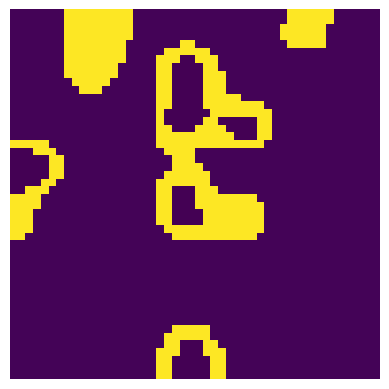

       patch_name  count
0  image_patch_83     21
1  image_patch_84     42
2  image_patch_85     33
3  image_patch_86     37
4  image_patch_89     24
x /content/gdrive/MyDrive/Crop_Mapping/Final_Data/2020_30km2_Guj/images_train_2020/image_patch_119
s2_data /content/gdrive/MyDrive/Crop_Mapping/Final_Data/2020_30km2_Guj/images_train_2020/image_patch_119
['2020-11-25.tiff', '2020-11-30.tiff', '2020-12-05.tiff', '2020-12-10.tiff', '2021-01-25.tiff', '2021-01-30.tiff', '2021-02-04.tiff', '2021-02-09.tiff', '2021-03-01.tiff', '2021-03-07.tiff', '2021-04-01.tiff', '2021-04-11.tiff', '2021-04-26.tiff']


  0%|          | 0/13 [00:00<?, ?it/s]

preds (48, 48, 1)
entropy (48, 48, 1)
Final number of superpixels: 144
[0.03045107]
[0.02494222]
[0.01880174]
[0.01564972]
[0.09431925]
[0.08388405]
[0.10724319]
[0.318003]
[0.06263114]
[0.01767844]
[0.03738367]
[0.18980783]
[0.01027146]
[0.01164849]
[0.01736391]
[0.01303719]
[0.05182718]
[0.31786522]
[0.10422344]
[0.28087905]
[0.10895894]
[0.01797645]
[0.02098876]
[0.04854313]
[0.01236071]
[0.01512455]
[0.01448605]
[0.01363532]
[0.04552049]
[nan]
[0.29341641]
[0.28872359]
[0.0458846]
[0.01360509]
[0.01033509]
[0.02041504]
[0.01095554]
[nan]
[0.01123116]
[0.01294868]
[0.0235531]
[0.04245828]
[0.0179368]
[0.04228425]
[0.01129036]
[0.01238405]
[0.00829933]
[0.0147525]
[0.01513438]
[0.01668607]
[0.01365959]
[0.01040742]
[0.02312542]
[0.01533292]
[0.01231518]
[0.01143086]
[0.00994968]
[0.04007879]
[0.010045]
[0.01371707]
[0.04253292]
[0.05873588]
[0.07922437]
[0.01477524]
[0.06162614]
[0.0267695]
[0.01421321]
[0.05318353]
[nan]
[0.29858199]
[0.04009874]
[0.01574715]
[0.3294746]
[0.31691805

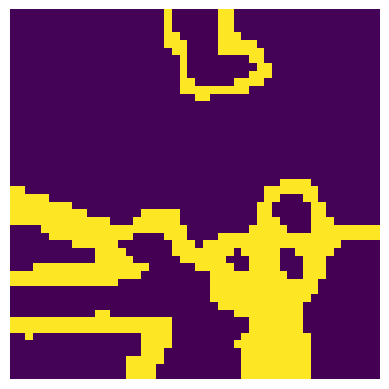

       patch_name  count
0  image_patch_83     21
1  image_patch_84     42
2  image_patch_85     33
3  image_patch_86     37
4  image_patch_89     24
x /content/gdrive/MyDrive/Crop_Mapping/Final_Data/2020_30km2_Guj/images_train_2020/image_patch_120
s2_data /content/gdrive/MyDrive/Crop_Mapping/Final_Data/2020_30km2_Guj/images_train_2020/image_patch_120
['2020-11-25.tiff', '2020-11-30.tiff', '2020-12-05.tiff', '2020-12-10.tiff', '2021-01-25.tiff', '2021-01-30.tiff', '2021-02-04.tiff', '2021-02-09.tiff', '2021-03-01.tiff', '2021-03-07.tiff', '2021-04-01.tiff', '2021-04-11.tiff', '2021-04-26.tiff']


  0%|          | 0/13 [00:00<?, ?it/s]

preds (48, 48, 1)
entropy (48, 48, 1)
Final number of superpixels: 144
[0.0397755]
[0.03614401]
[0.04861449]
[0.11441868]
[nan]
[0.11324586]
[0.29627243]
[0.09470326]
[0.1140926]
[0.11131295]
[0.11995132]
[0.10410661]
[0.01862905]
[0.01675109]
[0.01381753]
[0.01716726]
[0.01877577]
[0.04132421]
[0.03774926]
[0.28350881]
[0.13698162]
[0.29863444]
[0.30097589]
[0.1218588]
[0.02224836]
[0.02137498]
[0.0202654]
[0.01712984]
[0.01308248]
[0.01384906]
[0.01248773]
[0.00975851]
[0.03836312]
[0.08037914]
[0.2945593]
[nan]
[0.01798858]
[0.01758179]
[0.02011621]
[0.02630456]
[0.02056519]
[0.01224843]
[0.01448887]
[0.0129506]
[0.01275443]
[0.05950193]
[0.29611942]
[0.12140301]
[0.01666989]
[0.02088987]
[0.02114627]
[0.02840963]
[0.03310372]
[0.0266887]
[0.02568791]
[0.021792]
[0.02101537]
[0.02459079]
[0.0459785]
[0.29183781]
[0.02494919]
[0.01668396]
[0.02170889]
[0.03105907]
[0.02923556]
[0.03007771]
[0.02037625]
[0.02836893]
[0.0245525]
[0.0353336]
[0.03301404]
[0.05824463]
[0.02067098]
[0.015

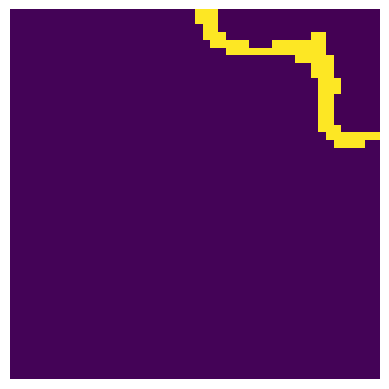

       patch_name  count
0  image_patch_83     21
1  image_patch_84     42
2  image_patch_85     33
3  image_patch_86     37
4  image_patch_89     24
incorrect_predictions 1st iteration


In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def create_prediciton_dataset():
  i=0

  # set parameters for superpixel segmentation
  num_superpixels = 400  # desired number of superpixels
  num_iterations = 4     # number of pixel level iterations. The higher, the better quality
  prior = 2              # for shape smoothing term. must be [0, 5]
  num_levels = 4
  num_histogram_bins = 5 # number of histogram bins


  image_patch_df = []
  counts_df = []
  loop = 24
  threshold = 0.25
  non_wheat_threshold= 0.30
  sample_num = 5 #for MC dropout
  # num_segments = 25 #for superpixels
  percent_threshold = 80

  df=pd.DataFrame()
  #enumerate for the time-series of each patch (with all its bands)
  for ids, folder in enumerate(data_folders):
    print(folder)


    if folder == 'images_train_2020':
    # if folder == 'patches':
      s2_data_path = os.path.join(data_path, folder)                            #/content/gdrive/MyDrive/Crop Mapping/Sentinel Hub Dataset for Code/1 S2_10m_all bands upsampled_5.5months_bboxtodimensions/Data.tiff
      print("s2_data_path", s2_data_path)
      loop_count = 0

        ##******************************SELECT ONLY TOP X IMAGES TO PREDICT*******************************

      for each_patch in os.listdir(s2_data_path):
        loop_count = loop_count + 1
        if loop_count > loop:
          break

        ##******************************LOAD DATA****************************************

        s2_data = os.path.join(s2_data_path, each_patch)
        print("x", s2_data)
        # if s2_data=='/content/gdrive/MyDrive/Crop Mapping/Final_Data/image_patch_48':
        #   print("x")
        print("s2_data", s2_data)                                                          #/content/gdrive/MyDrive/Crop Mapping/Psuedo_Labels/image patches/image_patch_64
        patch_timestamp = next(os.walk(s2_data))[2]
        # print("w")
        print(patch_timestamp)                                                       #['2021-11-20.tiff', '2021-11-26.tiff'....
        result_arr=[]
        i=0
        for ids2, tiff_file in enumerate(tqdm(patch_timestamp)):
          # print(tiff_file)                                                          #2021-12-05.tiff
          if i == 0:
            ds, labels = raster.read(os.path.join(s2_data, tiff_file))
            i=i+1
          img = gdal.Open(os.path.join(s2_data, tiff_file))                  #open each tiff file (with all its bands)
          x_img_arr = img.ReadAsArray()  #(12, 98, 99)
          # x_img_arr =  x_img_arr.reshape(13, 80, 80)
          # print(x_img_arr.shape)
          x_img_arr = x_img_arr[:12, :, :]
          # print(x_img_arr.shape)
          x_img_arr = np.transpose(x_img_arr, (1, 2, 0))   #(98,99,12)
          # print(x_img_arr.shape)
          result_arr.append(x_img_arr)                    #reshape from (12, 79, 137) to (137, 79, 12)->(height, width, bands)
          # print('result_arr', result_arr.shape)

        result_arr1 = np.stack(result_arr, axis=0)
        # result_arr1 = tf.image.resize(result_arr1, [80, 80])

        ##******************************Model Prediction*******************************

        pred = []
        for j in range(sample_num):
            # print(j)
            X_test1 = tf.expand_dims(result_arr1, axis = 0) #(1, 50, 48, 48, 12)
            # print("x", X_test1.shape)
            predcition = model(X_test1, training=True)
        #     print("prediction", predcition.shape) #(1, 48, 48, 1)
            predcition = np.squeeze(predcition, axis = 0)
        #         print("prediction", predcition.shape) #(1, 48, 48, 1)
            pred.append(predcition)

        # entropy = -pred*np.log(pred)
        y = np.stack(pred)
        # print("Y", y.shape)
        preds = tf.math.reduce_mean(y, axis= 0)
        print("preds", preds.shape)

        ##******************************Entropy*******************************




        preds = preds.numpy()
        entropy = -preds*np.log(preds)
        # print("entropy", entropy.shape)
        # entropy = tf.expand_dims(entropy, axis=-1)
        print("entropy", entropy.shape)

        # log_probs = np.log(preds)
        # print(log_probs.shape)
        # log_exp = np.sum(np.exp(log_probs), axis=-1)

        # # Normalize the log probabilities
        # norm_log_probs = log_probs - np.log(log_exp)
        # print("norm_log_probs", log_exp.shape)
        # print(norm_log_probs.min())
        # print(norm_log_probs.max())

        # # Calculate the maximum normalized log probability
        # entropy = np.max(norm_log_probs, axis = -1)
        # print("entropy", entropy.shape)


      # ##////////////Adaptive Mean Entropy////////////////
      #   # print('entropy mean', np.mean(entropy))
      #   # threshold = np.mean(entropy)

      # #////////////Adaptive 80th percentile Entropy////////////////
      #   # pixel_values = tf.reshape(entropy, [-1])
      #   # threshold = np.percentile(pixel_values, percent_threshold)  # Compute the 80th percentile value
      #   # print('threshold_val', threshold)

      # #   ##******************************Superpixel*******************************

      #   # num_segments = 100
      #   # labels = seg.slic(entropy, n_segments=num_segments, compactness=100)
      #   # # print(labels.shape)


        height, width = entropy.shape[0], entropy.shape[1]

        # initialize SEEDS algorithm
        seeds = cv2.ximgproc.createSuperpixelSEEDS(width, height, 1, num_superpixels, num_levels, prior, num_histogram_bins)
        img = entropy
        # run SEEDS
        img1 = np.squeeze(img, axis=-1)
        seeds.iterate(img1, num_iterations)

        # get number of superpixel
        num_of_superpixels_result = seeds.getNumberOfSuperpixels()
        print('Final number of superpixels: %d' % num_of_superpixels_result)

        # retrieve the segmentation result
        labels = seeds.getLabels() # height x width matrix. Each component indicates the superpixel index of the corresponding pixel position
        # print(labels)
        # draw contour
        # mask = seeds.getLabelContourMask(False)
        # print(np.unique(mask))

        # cv2_imshow(mask)

        # calculate the average color for each superpixel
        values = np.zeros((num_of_superpixels_result, entropy.shape[2]))
        superpixel_img = np.zeros_like(entropy)
        incorrect_superpixel_img = np.zeros_like(entropy)


        for i in range(num_of_superpixels_result):
            mask = labels == i
            values[i] = np.mean(entropy[mask], axis=0)
            print(values[i])
            if values[i] >= threshold:
              superpixel_img[mask] = 99
              incorrect_superpixel_img[mask] = (preds[mask]>0.50).astype(int)
            else:
              # newPredicted4 = (predcition1>0.50).astype(int)
              superpixel_img[mask] = (preds[mask]>0.50).astype(int)
              incorrect_superpixel_img[mask] = (preds[mask]>0.50).astype(int)
              # superpixel_img[mask] = entropy[mask] ##to visualaize and save entropy


        # bins= [0, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]
        # plt.hist(values, bins=bins, edgecolor="k")
        # plt.xticks(bins)
        # plt.show()
        #get count of superpixels if value > threshold
        count = 0
        for i in range(len(values)):
          # count = 0
          if values[i] >= threshold:
            count = count + 1
        print("count of superpixels greater than threshold", count)

        superpixel_img = np.squeeze(superpixel_img, axis=-1)
        plt.imshow(superpixel_img)
        plt.axis('off')
        plt.show()
        # print(superpixel_img.shape)

        #  ##******************************Find patches with MAJOR non wheat region *******************************

        # unique, w_counts = np.unique(incorrect_superpixel_img, return_counts=True)
        # print(unique)
        # print("w_counts", w_counts)
        # wheat_count = percent_ones = w_counts[1] / incorrect_superpixel_img.size #calculate 'Wheat' pixels % out of total
        # print("Percent of wheat in a patch", wheat_count)

# #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#         if count == 0:
#         #   #move entire folder of s2 data for a single patch to trainig set
#         #   #also move this superpixel mask to mask's forlder of training set as tiff file

#           predicted_patches_dir = '/content/gdrive/MyDrive/Crop_Mapping/Final_Data/data_split_with_augmentation/mask_sargodha_2021/'+str(each_patch)
#           first_image_patch_dir = os.path.exists(predicted_patches_dir)

#           if not first_image_patch_dir:
#             os.makedirs(predicted_patches_dir)

#           prediction_final = np.reshape(superpixel_img, (ds.RasterYSize, ds.RasterXSize))
#           raster.export(prediction_final, ds, filename=r'/content/gdrive/MyDrive/Crop_Mapping/Final_Data/data_split_with_augmentation/mask_sargodha_2021/'+str(each_patch)+"/"+str(each_patch), dtype='float')

#       #  ##******************************Move S2 data to Training set*******************************

#         predicted_patches_dir = '/content/gdrive/MyDrive/Crop_Mapping/Final_Data/data_split_with_augmentation/images_sargodha_2021/'
#         first_image_patch_dir = os.path.exists(predicted_patches_dir)

#         if not first_image_patch_dir:
#           os.makedirs(predicted_patches_dir)

#         shutil.move(s2_data, predicted_patches_dir)

#         # ##******************************Move Psuedo Predictions to INCORRECT PREDICTION set*******************************
#         # if (count != 0) or (wheat_count <= non_wheat_threshold):
#         if (count != 0):

#           predicted_patches_dir = '/content/gdrive/MyDrive/Crop_Mapping/Final_Data/Sargodha_2021/incorrect_predictions/'+str(each_patch)
#           first_image_patch_dir = os.path.exists(predicted_patches_dir)

#           if not first_image_patch_dir:
#             os.makedirs(predicted_patches_dir)

#           incorrect_prediction_final = np.reshape(incorrect_superpixel_img, (ds.RasterYSize, ds.RasterXSize))
#           raster.export(incorrect_prediction_final, ds, filename=r'/content/gdrive/MyDrive/Crop_Mapping/Final_Data/Sargodha_2021/incorrect_predictions/'+str(each_patch)+"/"+str(each_patch), dtype='float')

#           prediction_final = np.reshape(superpixel_img, (ds.RasterYSize, ds.RasterXSize))
#           raster.export(prediction_final, ds, filename=r'/content/gdrive/MyDrive/Crop_Mapping/Final_Data/Sargodha_2021/incorrect_predictions/'+str(each_patch)+"/"+str("incorrect") +str(each_patch), dtype='float')
# #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
      # #  ##******************************SAVE INCORRECT PREDICTION INFO TO DATAFRAME*******************************
        #******************************Move Psuedo Predictions to Training set (if none need updation)*******************************

        if count == 0:
        #   #move entire folder of s2 data for a single patch to trainig set
        #   #also move this superpixel mask to mask's forlder of training set as tiff file

          predicted_patches_dir = '/content/gdrive/MyDrive/Crop_Mapping/Final_Data/data_split_with_augmentation/masks_train/'+str(each_patch)
          first_image_patch_dir = os.path.exists(predicted_patches_dir)

          if not first_image_patch_dir:
            os.makedirs(predicted_patches_dir)

          prediction_final = np.reshape(superpixel_img, (ds.RasterYSize, ds.RasterXSize))
          raster.export(prediction_final, ds, filename=r'/content/gdrive/MyDrive/Crop_Mapping/Final_Data/data_split_with_augmentation/masks_train/'+str(each_patch)+"/"+str(each_patch), dtype='float')

      #  ##******************************Move S2 data to Training set*******************************

        predicted_patches_dir = '/content/gdrive/MyDrive/Crop_Mapping/Final_Data/data_split_with_augmentation/images_train/'
        first_image_patch_dir = os.path.exists(predicted_patches_dir)

        if not first_image_patch_dir:
          os.makedirs(predicted_patches_dir)

        shutil.move(s2_data, predicted_patches_dir)

        # ##******************************Move Psuedo Predictions to INCORRECT PREDICTION set*******************************
        # if (count != 0) or (wheat_count <= non_wheat_threshold):
        if (count != 0):

          predicted_patches_dir = '/content/gdrive/MyDrive/Crop_Mapping/Final_Data/2020_30km2_Guj/incorrect_predictions 2nd iteration/'+str(each_patch)
          first_image_patch_dir = os.path.exists(predicted_patches_dir)

          if not first_image_patch_dir:
            os.makedirs(predicted_patches_dir)

          incorrect_prediction_final = np.reshape(incorrect_superpixel_img, (ds.RasterYSize, ds.RasterXSize))
          raster.export(incorrect_prediction_final, ds, filename=r'/content/gdrive/MyDrive/Crop_Mapping/Final_Data/2020_30km2_Guj/incorrect_predictions 2nd iteration/'+str(each_patch)+"/"+str(each_patch), dtype='float')

          prediction_final = np.reshape(superpixel_img, (ds.RasterYSize, ds.RasterXSize))
          raster.export(prediction_final, ds, filename=r'/content/gdrive/MyDrive/Crop_Mapping/Final_Data/2020_30km2_Guj/incorrect_predictions 2nd iteration/'+str(each_patch)+"/"+str("incorrect") +str(each_patch), dtype='float')

      # # #  ##******************************SAVE INCORRECT PREDICTION INFO TO DATAFRAME*******************************
        if count != 0:
          image_patch_df.append(each_patch)
          counts_df.append(count)


        df = pd.DataFrame({'patch_name': image_patch_df, 'count': counts_df})
        # df['patch_name', 'count'] = each_patch, count
        print(df.head())

        # break
      df.to_csv("Incorrect psuedo details with 1st itr model.csv")



  # return result_arr, ds                                                               #return each tiff with all timestamps
data_path = '/content/gdrive/MyDrive/Crop_Mapping/Final_Data/2020_30km2_Guj/'
# data_path = '/content/gdrive/MyDrive/Crop_Mapping/Final_Data/Sargodha_2021/'
# data_path = '/content/gdrive/MyDrive/Crop Mapping/'
# data_path = '/content/gdrive/MyDrive/Crop Mapping/Testing batch prediction for active labelling/'
data_folders = next(os.walk(data_path))[1]
# print(data_folders)                                                              ##data_folders=  Data.json', 'Data.tiff', 'Mask'


# result_arr, ds = create_prediciton_dataset()                                                #create dataset with shape (time, height, width, bands)->(29, 79, 137, 12)
create_prediciton_dataset()